In [2]:
import sys, os, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, pdw2, cf2, make_folds
from features_glm import build_glm_features

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet").copy()
df.head()
df_glm = build_glm_features(df)


In [3]:
df_glm.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733


In [57]:
# Region als Kategorie + Baseline nach größter Exposure
df_glm["Region"] = df_glm["Region"].astype("category")

overall_freq = df_glm["ClaimNb"].sum() / df_glm["Exposure"].sum()
reg = (df_glm.groupby("Region", observed=True)
       .agg(expo=("Exposure","sum"), claims=("ClaimNb","sum"))
       .assign(freq=lambda x: x["claims"]/x["expo"])
       .sort_values("expo", ascending=False))
baseline_region = reg.index[0]
print(f"Overall freq: {overall_freq:.5f} | Baseline region: {baseline_region}")

# AreaGLM numerisch (nur für Replikation des R-Setups)
area_cat = df_glm["Area"].astype("category")
cats = sorted(area_cat.cat.categories)               # deterministische Reihenfolge
df_glm["AreaGLM"] = area_cat.cat.set_categories(cats, ordered=True).cat.codes + 1  # 1..K

# Folds (5, Seed=42), Fold 5 = Test
if "fold" not in df_glm.columns:
    df_glm["fold"] = make_folds(len(df_glm), k=5, seed=42)
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

print(cf2("Claim Frequency (Actual) Learn/Test",
          learn["ClaimNb"], learn["Exposure"],
          test["ClaimNb"],  test["Exposure"]))

cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
learn_pred = cf * learn["Exposure"]
test_pred  = cf * test["Exposure"]

print(pdw2("Poisson Deviance INT",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

Overall freq: 0.07368 | Baseline region: Centre
Claim Frequency (Actual) Learn/Test: 7.37% / 7.38%
Poisson Deviance INT, Learn/Test: 31.14% / 31.26%


In [5]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families

formula = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ AreaGLM"   
)

glm1 = smf.glm(
    formula=formula,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542693
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85960.
Date:                Sat, 11 Oct 2025   Deviance:                   1.3129e+05
Time:                        09:25:02   Pearson chi2:                 9.34e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01100
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [6]:
# Learn: fittedvalues enthalten Offset bereits
learn_pred = glm1.fittedvalues

# Test: Offset explizit mitgeben
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

print(pdw2("Poisson Deviance GLM1",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM1, Test-Sample, Actual/Predicted",
          test["ClaimNb"], test["Exposure"],
          test_pred,      test["Exposure"]))


Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Claim Frequency GLM1, Test-Sample, Actual/Predicted: 7.38% / 7.36%


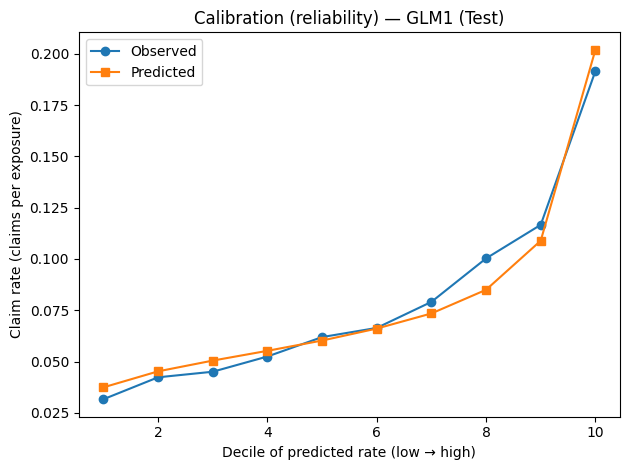

In [7]:
import matplotlib.pyplot as plt


test = df_glm[df_glm["fold"]==5].copy()
# Vorhergesagte Counts aus GLM1:
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

# Predicted rate = μ / Exposure
pred_rate = test_pred / test["Exposure"]

# Dezile bilden
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({
        "decile": dec,
        "expo": test["Exposure"].to_numpy(),
        "claims": test["ClaimNb"].to_numpy(),
        "pred": test_pred.to_numpy()
      })
      .groupby("decile",observed=False)
      .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
      .assign(obs_rate=lambda d: d["claims"]/d["expo"],
              pred_rate=lambda d: d["pred"]/d["expo"])
      .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate (claims per exposure)")
plt.title("Calibration (reliability) — GLM1 (Test)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from metrics import pdw

# 1) Modell mit AreaGLM : Test-PDW als Referenz
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))
pdw_glm1_test = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])

# 2) Gleiches Modell, aber Area als Kategorie 
formula_area_cat = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ C(Area)"  
)

glm1_areaC = smf.glm(formula=formula_area_cat, data=learn,
                     family=families.Poisson(),
                     offset=np.log(learn["Exposure"])).fit()

test_pred_areaC = glm1_areaC.predict(test, offset=np.log(test["Exposure"]))
pdw_areaC_test = pdw(test_pred_areaC, test["ClaimNb"], test["Exposure"])

print(f"Test PDW — GLM1 (AreaGLM numeric): {pdw_glm1_test:.2f}%")
print(f"Test PDW — GLM1 (C(Area) categorical): {pdw_areaC_test:.2f}%")
print(f"ΔPDW (categorical - numeric): {pdw_areaC_test - pdw_glm1_test:+.2f} pp")


Test PDW — GLM1 (AreaGLM numeric): 29.55%
Test PDW — GLM1 (C(Area) categorical): 29.55%
ΔPDW (categorical - numeric): +0.00 pp


In [9]:
from scipy.stats import chi2

# Zahl der Area-Stufen (für DF-Differenz)
n_levels_area = df_glm["Area"].astype("category").cat.categories.size
df_diff = (n_levels_area - 1) - 1  # (K-1) Dummies vs. 1 Numerik

LR = 2.0 * (glm1_areaC.llf - glm1.llf)
pval = 1.0 - chi2.cdf(LR, df_diff)

print(f"LR stat = {LR:.3f}, df = {df_diff}, p = {pval:.4g}")
print(f"AIC  numeric = {glm1.aic:.1f} | categorical = {glm1_areaC.aic:.1f} | del AIC = {glm1_areaC.aic - glm1.aic:+.3f}")
print(f"BIC  numeric = {glm1.bic if hasattr(glm1,'bic') else float('nan'):.1f} "
      f"| categorical = {glm1_areaC.bic if hasattr(glm1_areaC,'bic') else float('nan'):.1f}")


LR stat = 6.045, df = 4, p = 0.1958
AIC  numeric = 172016.0 | categorical = 172018.0 | del AIC = +1.955
BIC  numeric = -7034633.9 | categorical = -7034587.2


/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## GLM1 – Kurzbericht 
**Setup.**  
Poisson-GLM für $\,\text{ClaimNb}\,$ mit **Offset** $\log(\text{Exposure})$.  
Features nach Schelldorfer & Wüthrich (2019):  
$VehPowerGLM,\; VehAgeGLM,\; DrivAgeGLM,\; BonusMalusGLM,\; VehBrand,\; VehGas,\; DensityGLM,\; Region,\; AreaGLM.$  
Split: 5 Folds (Seed 42), **Fold 5 = Test (~20 %)**.

---

### Baselines
- Claim Frequency (Actual) Learn/Test: **7.38 % / 7.36 %**  
- **INT** (Intercept-only) Poisson-Deviance Test: **≈ 31 %** *(Referenzniveau)*

---

### GLM1 (klassenbasiert, wie Quelle)
- **Poisson Deviance Learn/Test:** **29.54 % / 29.55 %**  
  $$\Downarrow\quad\text{Verbesserung ggü. INT um ca. }1.5\ \text{pp (Test).}$$
- **Claim Frequency (Test, Actual/Predicted):** **7.38 % / 7.36 %**  
  → **Niveau-Kalibrierung passt** (durchschnittliche Rate korrekt).

---

### Area-Kodierung (Sanity-Check)
Vergleich $AreaGLM$ (numerisch) vs. $C(Area)$ (kategorisch/Dummy):
- **Test-PDW:** **29.55 % vs. 29.55 %** ($\Delta = 0.00$ pp)
- **LR-Test:** $\chi^2=6.045,\ \text{df}=4,\ p=0.1958$ → *kein signifikanter Gewinn* durch $C(Area)$  
- **AIC:** numerisch $=172016.0$ | kategorisch $=172018.0$ → $\Delta \text{AIC} = +1.955$ *(kategorisch minus numerisch)*

**Fazit:** $Area$ trägt in diesem Setup **kaum**; wir behalten **$AreaGLM$**.

---

### Exkurs: AIC 
Der **Akaike Information Criterion** misst Güte vs. Komplexität:
$$
\text{AIC} = 2k \;-\; 2\ell,
$$
mit $k=$ Anzahl freier Parameter und $\ell=$ maximierter Log-Likelihood.  
**Kleiner** ist **besser**. Richtwerte:
- $\Delta \text{AIC} < 2$: Modelle sind **praktisch gleichwertig**.  
- $4\text{–}7$: **schwacher** Vorteil.  
- $>10$: **klarer** Vorteil.

Hier ist $\Delta \text{AIC}\approx 2$ → **keine** belastbare Verbesserung durch die Dummy-Kodierung; der einfachere $AreaGLM$ ist angemessen.



In [10]:
###GLM2 setup

for part in (learn, test):
    part["log_DrivAge"] = np.log(part["DrivAge"].astype(float))
    part["DrivAge2"] = part["DrivAge"].astype(float)**2
    part["DrivAge3"] = part["DrivAge"].astype(float)**3
    part["DrivAge4"] = part["DrivAge"].astype(float)**4

In [11]:
baseline_region = "Centre"

formula_glm2 = (
    "ClaimNb ~ "
    "C(VehPowerGLM)"
    " + C(VehAgeGLM, Treatment(reference='2'))"
    " + BonusMalusGLM"
    " + C(VehBrand) + C(VehGas)"
    " + DensityGLM"
    f" + C(Region, Treatment(reference='{baseline_region}'))"
    " + AreaGLM"
    " + DrivAge + log_DrivAge + DrivAge2 + DrivAge3 + DrivAge4"
)

glm2 = smf.glm(
    formula=formula_glm2,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm2.summary())  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542695
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85931.
Date:                Sat, 11 Oct 2025   Deviance:                   1.3124e+05
Time:                        09:25:28   Pearson chi2:                 9.32e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01110
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [12]:
# GLM2: Learn/Test-Predictions
learn_pred_glm2 = glm2.fittedvalues
test_pred_glm2  = glm2.predict(test, offset=np.log(test["Exposure"]))

# INT-Baseline (wie zuvor)
cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
test_pred_int = cf * test["Exposure"]
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))

# PDW/CF report
print(pdw2("Poisson Deviance GLM1",
           glm1.fittedvalues, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm1,  test["ClaimNb"],  test["Exposure"]))

print(pdw2("Poisson Deviance GLM2",
           learn_pred_glm2, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm2,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM2, Test (Actual/Predicted)",
          test["ClaimNb"], test["Exposure"],
          test_pred_glm2,  test["Exposure"]))

# Verbesserung gg. INT (auf Test)
pdw_int  = pdw(test_pred_int,  test["ClaimNb"], test["Exposure"])
pdw_g1   = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])
pdw_g2   = pdw(test_pred_glm2, test["ClaimNb"], test["Exposure"])

print(f"PDW(Test) INT={pdw_int:.2f}% | GLM1={pdw_g1:.2f}% | GLM2={pdw_g2:.2f}% "
      f"| Δ(GLM2-GLM1)={pdw_g2 - pdw_g1:+.2f} pp")

Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Poisson Deviance GLM2, Learn/Test: 29.53% / 29.52%
Claim Frequency GLM2, Test (Actual/Predicted): 7.38% / 7.36%
PDW(Test) INT=31.26% | GLM1=29.55% | GLM2=29.52% | Δ(GLM2-GLM1)=-0.03 pp


## GLM2 – Kurzfazit & Vergleich zu GLM1 

**Setup.** Wie GLM1 (Poisson mit Offset $\log(\text{Exposure})$), zusätzlich kontinuierliche Terme für $\,\text{DrivAge}\,$:
\[
\log(\text{DrivAge}),\quad \text{DrivAge}^2,\ \text{DrivAge}^3,\ \text{DrivAge}^4.
\]

**Ergebnisse.**
- **Poisson-Deviance (Learn/Test):**  
  GLM1 **29.54 % / 29.55 %**  
  GLM2 **29.53 % / 29.52 %**  $\Rightarrow$ **$\Delta$ Test = −0.03 pp** (minimal besser)
- **Claim Frequency (Test, Actual/Pred):** **7.38 % / 7.36 %**
- **vs. INT (Test-PDW 31.26 %)**:  
  GLM1 verbessert um **1.71 pp**, GLM2 um **1.74 pp**.

**Interpretation.**  
Die zusätzlichen nichtlinearen $\,\text{DrivAge}$-Terme liefern einen **kleinen, aber konsistenten** Gewinn ggü. GLM1. Das deutet auf leichte Nichtlinearität in der Alterswirkung hin; größere Sprünge sind ohne weitere Glättung/Interaktionen nicht zu erwarten. Für mehr Flexibilität bietet sich als nächstes ein **GAM** mit Splines an (oder Interaktionen wie $\text{DrivAge}\times\text{BonusMalus}$ – stets out-of-sample prüfen).


In [14]:
import os, sys, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, cf2, make_folds

from glum import GeneralizedLinearRegressorCV
from dask_ml.preprocessing import Categorizer


cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

X_learn = learn[cat_cols + num_cols]
X_test  = test[cat_cols + num_cols]

# Optional: vereinheitlichte Kategoriensätze (falls Learn/Test nicht dieselben Levels haben)
cat = Categorizer(columns=cat_cols)
X_learn = cat.fit_transform(X_learn)
X_test  = cat.transform(X_test)

# Ziel als Frequenz + Gewichte = Exposure (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()

# Poisson-LASSO mit CV
lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson",
    l1_ratio=1.0,      # LASSO
    cv=5,
    n_alphas=60,
    random_state=42,
    verbose=1,
)
lasso_cv.fit(X_learn, y_learn, sample_weight=w_learn)

print("gewähltes alpha_*:", lasso_cv.alpha_)
# Optional: Pfad & CV-Infos
print(lasso_cv.alphas_[:5], "…")



Iteration 0: |                              | 0/? [s/it, gradient norm=1.734723475976807e-18]


alpha=5.490e-01, time=0.07s, n_iter=0


Iteration 1:  61%|██████████▎      | 1.22/2.0 [0.16s/it, gradient norm=0.0005961086105021175]


alpha=4.344e-01, time=0.37s, n_iter=2


Iteration 1:  54%|█████████        | 1.07/2.0 [0.11s/it, gradient norm=0.0008521741085897965]


alpha=3.437e-01, time=0.33s, n_iter=2


Iteration 1:  67%|███████████▍     | 1.34/2.0 [0.11s/it, gradient norm=0.0004561222282531258]


alpha=2.720e-01, time=0.35s, n_iter=2


Iteration 1:  80%|█████████████▌   | 1.59/2.0 [0.14s/it, gradient norm=0.0002573458583267148]


alpha=2.152e-01, time=0.35s, n_iter=2


Iteration 1:  91%|██████████████▌ | 1.82/2.0 [0.14s/it, gradient norm=0.00014969112428200914]


alpha=1.703e-01, time=0.51s, n_iter=2


Iteration 0:  30%|█████▋             | 0.6/2.0 [0.17s/it, gradient norm=0.002507608003206223]


alpha=1.347e-01, time=0.49s, n_iter=1


Iteration 0:  36%|██████▋            | 0.71/2.0 [0.14s/it, gradient norm=0.00194879209757494]


alpha=1.066e-01, time=0.45s, n_iter=1


Iteration 0:  40%|███████▎          | 0.81/2.0 [0.18s/it, gradient norm=0.001550384754360238]


alpha=8.434e-02, time=0.38s, n_iter=1


Iteration 0:  46%|███████▋         | 0.91/2.0 [0.17s/it, gradient norm=0.0012299144395120408]


alpha=6.673e-02, time=0.43s, n_iter=1


Iteration 0:   1%|▏                | 0.01/1.0 [0.13s/it, gradient norm=0.0009752144584006448]


alpha=5.280e-02, time=0.34s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.17s/it, gradient norm=0.0007729048510843452]


alpha=4.178e-02, time=0.38s, n_iter=1


Iteration 0:  21%|███▌             | 0.21/1.0 [0.16s/it, gradient norm=0.0006137755121482299]


alpha=3.306e-02, time=0.36s, n_iter=1


Iteration 0:  31%|█████▎           | 0.31/1.0 [0.12s/it, gradient norm=0.0004862382140395534]


alpha=2.616e-02, time=0.28s, n_iter=1


Iteration 0:  41%|██████▉          | 0.41/1.0 [0.13s/it, gradient norm=0.0003850970415115167]


alpha=2.069e-02, time=0.34s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.18s/it, gradient norm=0.0015369590494680528]


alpha=1.637e-02, time=0.45s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.17s/it, gradient norm=0.0020704293086008883]


alpha=1.296e-02, time=0.48s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.18s/it, gradient norm=0.0016439959501863826]


alpha=1.025e-02, time=0.46s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.18s/it, gradient norm=0.0012995455864404644]


alpha=8.111e-03, time=0.31s, n_iter=1


Iteration 0:  50%|████████▍        | 0.99/2.0 [0.09s/it, gradient norm=0.0010271219499454426]


alpha=6.418e-03, time=0.23s, n_iter=1


Iteration 0:   9%|█▌               | 0.09/1.0 [0.09s/it, gradient norm=0.0008120008480523551]


alpha=5.078e-03, time=0.21s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.09s/it, gradient norm=0.0006420543985727828]


alpha=4.018e-03, time=0.22s, n_iter=1


Iteration 0:  27%|████▌            | 0.27/1.0 [0.10s/it, gradient norm=0.0005378634093154548]


alpha=3.179e-03, time=0.22s, n_iter=1


Iteration 0:  25%|████▊              | 0.5/2.0 [0.09s/it, gradient norm=0.003135255601162968]


alpha=2.515e-03, time=0.28s, n_iter=1


Iteration 0:  22%|███▊             | 0.45/2.0 [0.11s/it, gradient norm=0.0035412338122638594]


alpha=1.990e-03, time=0.31s, n_iter=1


Iteration 0:  12%|██                | 0.23/2.0 [0.06s/it, gradient norm=0.005879080335589641]


alpha=1.575e-03, time=0.31s, n_iter=1


Iteration 1:  93%|██████████████▉ | 1.86/2.0 [0.21s/it, gradient norm=0.00013951649044314065]


alpha=1.246e-03, time=0.52s, n_iter=2


Iteration 1:  94%|███████████████ | 1.88/2.0 [0.21s/it, gradient norm=0.00013105637699554296]


alpha=9.859e-04, time=0.50s, n_iter=2


Iteration 0:  11%|█▉                | 0.22/2.0 [0.16s/it, gradient norm=0.006038364424111322]


alpha=7.801e-04, time=0.37s, n_iter=1


Iteration 0:  15%|██▊                | 0.3/2.0 [0.09s/it, gradient norm=0.005052463723925324]


alpha=6.172e-04, time=0.28s, n_iter=1


Iteration 0:  15%|██▊                | 0.3/2.0 [0.11s/it, gradient norm=0.004995634341433692]


alpha=4.884e-04, time=0.32s, n_iter=1


Iteration 0:  20%|███▊               | 0.4/2.0 [0.07s/it, gradient norm=0.003993172403949475]


alpha=3.864e-04, time=0.28s, n_iter=1


Iteration 0:  19%|███▍              | 0.38/2.0 [0.08s/it, gradient norm=0.004172549640392858]


alpha=3.057e-04, time=0.36s, n_iter=1


Iteration 0:  18%|███              | 0.36/2.0 [0.17s/it, gradient norm=0.0043412134365164706]


alpha=2.419e-04, time=0.46s, n_iter=1


Iteration 0:  21%|███▌             | 0.42/2.0 [0.16s/it, gradient norm=0.0037885650518095296]


alpha=1.914e-04, time=0.44s, n_iter=1


Iteration 0:  24%|████▍             | 0.49/2.0 [0.09s/it, gradient norm=0.003243800877293565]


alpha=1.515e-04, time=0.36s, n_iter=1


Iteration 0:  26%|████▊             | 0.53/2.0 [0.09s/it, gradient norm=0.002922518640781348]


alpha=1.198e-04, time=0.32s, n_iter=1


Iteration 0:  27%|████▌            | 0.54/2.0 [0.07s/it, gradient norm=0.0028837367893274845]


alpha=9.482e-05, time=0.38s, n_iter=1


Iteration 0:  28%|████▊            | 0.56/2.0 [0.18s/it, gradient norm=0.0027788069016082854]


alpha=7.502e-05, time=0.55s, n_iter=1


Iteration 0:  32%|█████▋            | 0.63/2.0 [0.15s/it, gradient norm=0.002345636931586615]


alpha=5.936e-05, time=0.43s, n_iter=1


Iteration 0:  34%|██████▏           | 0.69/2.0 [0.13s/it, gradient norm=0.002030684057831916]


alpha=4.697e-05, time=0.47s, n_iter=1


Iteration 0:  38%|██████▍          | 0.76/2.0 [0.15s/it, gradient norm=0.0017328936557476087]


alpha=3.716e-05, time=0.51s, n_iter=1


Iteration 0:  42%|███████▏         | 0.84/2.0 [0.18s/it, gradient norm=0.0014467038570721927]


alpha=2.940e-05, time=0.50s, n_iter=1


Iteration 0:  45%|████████▌          | 0.9/2.0 [0.17s/it, gradient norm=0.001265403754054942]


alpha=2.327e-05, time=0.50s, n_iter=1


Iteration 0:  50%|████████▍        | 0.99/2.0 [0.15s/it, gradient norm=0.0010324417033797675]


alpha=1.841e-05, time=0.46s, n_iter=1


Iteration 0:   7%|█▏               | 0.07/1.0 [0.16s/it, gradient norm=0.0008439312309464434]


alpha=1.457e-05, time=0.47s, n_iter=1


Iteration 0:  13%|██▏              | 0.13/1.0 [0.12s/it, gradient norm=0.0007453239952526427]


alpha=1.152e-05, time=0.46s, n_iter=1


Iteration 0:  23%|███▉             | 0.23/1.0 [0.15s/it, gradient norm=0.0005923990675799804]


alpha=9.119e-06, time=0.48s, n_iter=1


Iteration 0:  33%|█████▎          | 0.33/1.0 [0.16s/it, gradient norm=0.00047043428099396084]


alpha=7.215e-06, time=0.49s, n_iter=1


Iteration 0:  41%|██████▉          | 0.41/1.0 [0.18s/it, gradient norm=0.0003875968856097304]


alpha=5.709e-06, time=0.48s, n_iter=1


Iteration 0:  49%|████████▎        | 0.49/1.0 [0.16s/it, gradient norm=0.0003263853015000564]


alpha=4.517e-06, time=0.47s, n_iter=1


Iteration 0:  59%|█████████▍      | 0.59/1.0 [0.16s/it, gradient norm=0.00025806970176621533]


alpha=3.574e-06, time=0.43s, n_iter=1


Iteration 0:  69%|███████████▋     | 0.69/1.0 [0.14s/it, gradient norm=0.0002040795968333153]


alpha=2.828e-06, time=0.60s, n_iter=1


Iteration 0:  77%|█████████████    | 0.77/1.0 [0.18s/it, gradient norm=0.0001693072688602134]


alpha=2.237e-06, time=0.66s, n_iter=1


Iteration 0:  85%|█████████████▌  | 0.85/1.0 [0.16s/it, gradient norm=0.00014219290611801655]


alpha=1.770e-06, time=0.51s, n_iter=1


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.15s/it, gradient norm=0.00011750340856354529]


alpha=1.401e-06, time=0.52s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.402627618387985e-05]


alpha=1.108e-06, time=0.15s, n_iter=0


Iteration 0:  80%|█████████████▌   | 0.8/1.0 [0.18s/it, gradient norm=0.00015985411872405407]


alpha=8.770e-07, time=0.53s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.469490526021723e-05]


alpha=6.939e-07, time=0.17s, n_iter=0


Iteration 0:  98%|████████████████▋| 0.98/1.0 [0.18s/it, gradient norm=0.0001057659766498296]


alpha=5.490e-07, time=0.53s, n_iter=1


Iteration 0: |                             | 0/? [s/it, gradient norm=1.9081958235744878e-17]


alpha=5.490e-01, time=0.10s, n_iter=0


Iteration 1:  46%|███████▊         | 0.92/2.0 [0.12s/it, gradient norm=0.0011992639137796799]


alpha=4.344e-01, time=0.34s, n_iter=2


Iteration 1:  55%|█████████▉        | 1.1/2.0 [0.16s/it, gradient norm=0.0007932002256799144]


alpha=3.437e-01, time=0.39s, n_iter=2


Iteration 1:  68%|█████████████      | 1.37/2.0 [0.15s/it, gradient norm=0.00043060340498426]


alpha=2.720e-01, time=0.35s, n_iter=2


Iteration 1:  80%|█████████████▋   | 1.61/2.0 [0.14s/it, gradient norm=0.0002442161547375737]


alpha=2.152e-01, time=0.34s, n_iter=2


Iteration 1:  92%|██████████████▊ | 1.85/2.0 [0.09s/it, gradient norm=0.00014259720975099257]


alpha=1.703e-01, time=0.28s, n_iter=2


Iteration 0:  30%|██████              | 0.6/2.0 [0.08s/it, gradient norm=0.00249264299299252]


alpha=1.347e-01, time=0.22s, n_iter=1


Iteration 0:  36%|██████           | 0.71/2.0 [0.09s/it, gradient norm=0.0019376036909457993]


alpha=1.066e-01, time=0.21s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.06s/it, gradient norm=0.0015412513490749694]


alpha=8.434e-02, time=0.18s, n_iter=1


Iteration 0:  46%|███████▋         | 0.91/2.0 [0.10s/it, gradient norm=0.0012226575317946468]


alpha=6.673e-02, time=0.19s, n_iter=1


Iteration 0:   1%|▏                | 0.01/1.0 [0.11s/it, gradient norm=0.0009694466795053354]


alpha=5.280e-02, time=0.22s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.08s/it, gradient norm=0.0007683258381129582]


alpha=4.178e-02, time=0.20s, n_iter=1


Iteration 0:  21%|███▌             | 0.21/1.0 [0.08s/it, gradient norm=0.0006102635252730015]


alpha=3.306e-02, time=0.23s, n_iter=1


Iteration 0:  32%|█████           | 0.32/1.0 [0.14s/it, gradient norm=0.00048345382596009243]


alpha=2.616e-02, time=0.31s, n_iter=1


Iteration 0:  42%|██████▋         | 0.42/1.0 [0.11s/it, gradient norm=0.00038288986304002635]


alpha=2.069e-02, time=0.26s, n_iter=1


Iteration 0:  41%|███████▍          | 0.82/2.0 [0.09s/it, gradient norm=0.001504684568727861]


alpha=1.637e-02, time=0.22s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.08s/it, gradient norm=0.0020729882101493654]


alpha=1.296e-02, time=0.21s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.10s/it, gradient norm=0.0016451858832425296]


alpha=1.025e-02, time=0.37s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.12s/it, gradient norm=0.0013007096549109381]


alpha=8.111e-03, time=0.41s, n_iter=1


Iteration 0:  50%|████████▍        | 0.99/2.0 [0.08s/it, gradient norm=0.0010281919943711082]


alpha=6.418e-03, time=0.21s, n_iter=1


Iteration 0:   9%|█▌               | 0.09/1.0 [0.10s/it, gradient norm=0.0008129419733145568]


alpha=5.078e-03, time=0.24s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.08s/it, gradient norm=0.0006428584612539815]


alpha=4.018e-03, time=0.22s, n_iter=1


Iteration 0:  29%|████▉            | 0.29/1.0 [0.08s/it, gradient norm=0.0005084233253257686]


alpha=3.179e-03, time=0.20s, n_iter=1


Iteration 0:  28%|█████▏            | 0.57/2.0 [0.08s/it, gradient norm=0.002717202898460263]


alpha=2.515e-03, time=0.29s, n_iter=1


Iteration 0:  18%|███▏              | 0.36/2.0 [0.07s/it, gradient norm=0.004355015306318008]


alpha=1.990e-03, time=0.28s, n_iter=1


Iteration 1:  90%|███████████████▎ | 1.8/2.0 [0.20s/it, gradient norm=0.00015857399062223942]


alpha=1.575e-03, time=0.43s, n_iter=2


Iteration 1:  89%|██████████████▏ | 1.78/2.0 [0.19s/it, gradient norm=0.00016765217700096818]


alpha=1.246e-03, time=0.41s, n_iter=2


Iteration 1:  92%|██████████████▋ | 1.83/2.0 [0.21s/it, gradient norm=0.00014813521063242234]


alpha=9.859e-04, time=0.51s, n_iter=2


Iteration 0:  10%|█▋                | 0.19/2.0 [0.16s/it, gradient norm=0.006423515202896056]


alpha=7.801e-04, time=0.37s, n_iter=1


Iteration 0:  12%|██▏               | 0.24/2.0 [0.08s/it, gradient norm=0.005750663607457372]


alpha=6.172e-04, time=0.34s, n_iter=1


Iteration 0:  14%|██▌               | 0.29/2.0 [0.15s/it, gradient norm=0.005184665447340878]


alpha=4.884e-04, time=0.35s, n_iter=1


Iteration 0:  18%|███▏              | 0.36/2.0 [0.14s/it, gradient norm=0.004340331107474432]


alpha=3.864e-04, time=0.35s, n_iter=1


Iteration 0:  20%|███▋              | 0.41/2.0 [0.10s/it, gradient norm=0.003930383274711134]


alpha=3.057e-04, time=0.35s, n_iter=1


Iteration 0:  20%|████                | 0.4/2.0 [0.13s/it, gradient norm=0.00400805147326785]


alpha=2.419e-04, time=0.31s, n_iter=1


Iteration 0:  22%|███▉              | 0.44/2.0 [0.13s/it, gradient norm=0.003629733393896272]


alpha=1.914e-04, time=0.44s, n_iter=1


Iteration 0:  23%|███▉             | 0.46/2.0 [0.18s/it, gradient norm=0.0034351592347691196]


alpha=1.515e-04, time=0.43s, n_iter=1


Iteration 0:  24%|████▍             | 0.49/2.0 [0.16s/it, gradient norm=0.003205087064118208]


alpha=1.198e-04, time=0.42s, n_iter=1


Iteration 0:  28%|████▋            | 0.55/2.0 [0.13s/it, gradient norm=0.0027880838056446146]


alpha=9.482e-05, time=0.42s, n_iter=1


Iteration 0:  28%|████▋            | 0.55/2.0 [0.15s/it, gradient norm=0.0027862900236056277]


alpha=7.502e-05, time=0.42s, n_iter=1


Iteration 0:  30%|█████▌             | 0.59/2.0 [0.08s/it, gradient norm=0.00256507554752829]


alpha=5.936e-05, time=0.34s, n_iter=1


Iteration 0:  34%|██████▏           | 0.69/2.0 [0.08s/it, gradient norm=0.002035339220633533]


alpha=4.697e-05, time=0.33s, n_iter=1


Iteration 0:  38%|██████▍          | 0.76/2.0 [0.08s/it, gradient norm=0.0017197281661439296]


alpha=3.716e-05, time=0.35s, n_iter=1


Iteration 0:  43%|███████▎         | 0.86/2.0 [0.08s/it, gradient norm=0.0013857656062011355]


alpha=2.940e-05, time=0.33s, n_iter=1


Iteration 0:  47%|███████▉         | 0.94/2.0 [0.06s/it, gradient norm=0.0011455290029030712]


alpha=2.327e-05, time=0.33s, n_iter=1


Iteration 0:   3%|▌                | 0.03/1.0 [0.11s/it, gradient norm=0.0009313682168012198]


alpha=1.841e-05, time=0.38s, n_iter=1


Iteration 0:  10%|█▊                | 0.1/1.0 [0.08s/it, gradient norm=0.0007885207307820108]


alpha=1.457e-05, time=0.37s, n_iter=1


Iteration 0:  13%|██▎               | 0.13/1.0 [0.06s/it, gradient norm=0.000743098491084556]


alpha=1.152e-05, time=0.34s, n_iter=1


Iteration 0:  21%|███▌             | 0.21/1.0 [0.10s/it, gradient norm=0.0006145224912620945]


alpha=9.119e-06, time=0.36s, n_iter=1


Iteration 0:  30%|█████▍            | 0.3/1.0 [0.08s/it, gradient norm=0.0005003522228870812]


alpha=7.215e-06, time=0.36s, n_iter=1


Iteration 0:  38%|██████          | 0.38/1.0 [0.09s/it, gradient norm=0.00041447729290664513]


alpha=5.709e-06, time=0.37s, n_iter=1


Iteration 0:  47%|███████▉         | 0.47/1.0 [0.06s/it, gradient norm=0.0003363104320461614]


alpha=4.517e-06, time=0.37s, n_iter=1


Iteration 0:  57%|█████████       | 0.57/1.0 [0.09s/it, gradient norm=0.00027180255737643957]


alpha=3.574e-06, time=0.32s, n_iter=1


Iteration 0:  64%|██████████▏     | 0.64/1.0 [0.08s/it, gradient norm=0.00022751912205042974]


alpha=2.828e-06, time=0.37s, n_iter=1


Iteration 0:  74%|███████████▊    | 0.74/1.0 [0.09s/it, gradient norm=0.00018235724197013898]


alpha=2.237e-06, time=0.35s, n_iter=1


Iteration 0:  83%|█████████████▎  | 0.83/1.0 [0.08s/it, gradient norm=0.00014915061047987967]


alpha=1.770e-06, time=0.36s, n_iter=1


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.08s/it, gradient norm=0.00012028223146641648]


alpha=1.401e-06, time=0.36s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.619470694636407e-05]


alpha=1.108e-06, time=0.08s, n_iter=0


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.09s/it, gradient norm=0.00016333561148227708]


alpha=8.770e-07, time=0.35s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.580566380890911e-05]


alpha=6.939e-07, time=0.09s, n_iter=0


Iteration 0:  97%|███████████████▌| 0.97/1.0 [0.06s/it, gradient norm=0.00010818377130466379]


alpha=5.490e-07, time=0.34s, n_iter=1


Iteration 1:  94%|████████████████ | 1.89/2.0 [0.12s/it, gradient norm=0.0001275967488888214]


alpha=5.490e-01, time=0.34s, n_iter=2


Iteration 1:  44%|███████▍         | 0.87/2.0 [0.11s/it, gradient norm=0.0013517938921752196]


alpha=4.344e-01, time=0.37s, n_iter=2


Iteration 1:  58%|█████████▊       | 1.16/2.0 [0.14s/it, gradient norm=0.0006927350482914211]


alpha=3.437e-01, time=0.34s, n_iter=2


Iteration 1:  71%|███████████▎    | 1.42/2.0 [0.12s/it, gradient norm=0.00038300298022639345]


alpha=2.720e-01, time=0.35s, n_iter=2


Iteration 1:  83%|█████████████▎  | 1.66/2.0 [0.14s/it, gradient norm=0.00021977218398002612]


alpha=2.152e-01, time=0.32s, n_iter=2


Iteration 1:  94%|███████████████ | 1.89/2.0 [0.18s/it, gradient norm=0.00012927858438967167]


alpha=1.703e-01, time=0.34s, n_iter=2


Iteration 0:  30%|█████▍            | 0.61/2.0 [0.10s/it, gradient norm=0.002469858347596307]


alpha=1.347e-01, time=0.20s, n_iter=1


Iteration 0:  36%|██████▊            | 0.72/2.0 [0.10s/it, gradient norm=0.00192271244207666]


alpha=1.066e-01, time=0.27s, n_iter=1


Iteration 0:  41%|██████▉          | 0.82/2.0 [0.09s/it, gradient norm=0.0015285637322455929]


alpha=8.434e-02, time=0.22s, n_iter=1


Iteration 0:  46%|███████▊         | 0.92/2.0 [0.08s/it, gradient norm=0.0012123747354401216]


alpha=6.673e-02, time=0.21s, n_iter=1


Iteration 0:   2%|▎                 | 0.02/1.0 [0.09s/it, gradient norm=0.000961145654488807]


alpha=5.280e-02, time=0.21s, n_iter=1


Iteration 0:  12%|██               | 0.12/1.0 [0.09s/it, gradient norm=0.0007616572918176219]


alpha=4.178e-02, time=0.22s, n_iter=1


Iteration 0:  22%|███▋             | 0.22/1.0 [0.08s/it, gradient norm=0.0006051223072775671]


alpha=3.306e-02, time=0.21s, n_iter=1


Iteration 0:  32%|█████▍           | 0.32/1.0 [0.07s/it, gradient norm=0.0004793492415009282]


alpha=2.616e-02, time=0.20s, n_iter=1


Iteration 0:  42%|███████▏         | 0.42/1.0 [0.08s/it, gradient norm=0.0003796185076908375]


alpha=2.069e-02, time=0.21s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.08s/it, gradient norm=0.0018475876772540967]


alpha=1.637e-02, time=0.22s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.06s/it, gradient norm=0.0020781174151758967]


alpha=1.296e-02, time=0.18s, n_iter=1


Iteration 0:  39%|███████           | 0.78/2.0 [0.08s/it, gradient norm=0.001647324803600624]


alpha=1.025e-02, time=0.16s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.12s/it, gradient norm=0.0013023898837472517]


alpha=8.111e-03, time=0.25s, n_iter=1


Iteration 0:  50%|████████▍        | 0.99/2.0 [0.12s/it, gradient norm=0.0010296217728743584]


alpha=6.418e-03, time=0.24s, n_iter=1


Iteration 0:   9%|█▌               | 0.09/1.0 [0.08s/it, gradient norm=0.0008141363686650832]


alpha=5.078e-03, time=0.20s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.07s/it, gradient norm=0.0006438429687418397]


alpha=4.018e-03, time=0.21s, n_iter=1


Iteration 0:  49%|████████▊         | 0.98/2.0 [0.10s/it, gradient norm=0.001054607130649405]


alpha=3.179e-03, time=0.22s, n_iter=1


Iteration 0:  24%|███▉             | 0.47/2.0 [0.10s/it, gradient norm=0.0033979975445667214]


alpha=2.515e-03, time=0.29s, n_iter=1


Iteration 0:  16%|██▋              | 0.32/2.0 [0.06s/it, gradient norm=0.0048230884003718786]


alpha=1.990e-03, time=0.26s, n_iter=1


Iteration 1:  94%|██████████████▉ | 1.87/2.0 [0.22s/it, gradient norm=0.00013399498558583234]


alpha=1.575e-03, time=0.44s, n_iter=2


Iteration 1:  87%|█████████████▉  | 1.74/2.0 [0.21s/it, gradient norm=0.00018139208801037817]


alpha=1.246e-03, time=0.42s, n_iter=2


Iteration 1:  96%|███████████████▎| 1.91/2.0 [0.24s/it, gradient norm=0.00012249762184768858]


alpha=9.859e-04, time=0.45s, n_iter=2


Iteration 1:  98%|████████████████████▋| 1.97/2.0 [0.19s/it, gradient norm=0.000108000463203]


alpha=7.801e-04, time=0.47s, n_iter=2


Iteration 1:  92%|██████████████▋ | 1.83/2.0 [0.22s/it, gradient norm=0.00014826534315627108]


alpha=6.172e-04, time=0.53s, n_iter=2


Iteration 1:  98%|███████████████▋| 1.96/2.0 [0.22s/it, gradient norm=0.00011027025050563377]


alpha=4.884e-04, time=0.55s, n_iter=2


Iteration 0:  17%|███▏               | 0.34/2.0 [0.06s/it, gradient norm=0.00454828448228985]


alpha=3.864e-04, time=0.28s, n_iter=1


Iteration 0:  18%|███              | 0.36/2.0 [0.09s/it, gradient norm=0.0043738700586130955]


alpha=3.057e-04, time=0.29s, n_iter=1


Iteration 0:  19%|███▍              | 0.38/2.0 [0.08s/it, gradient norm=0.004185067156608143]


alpha=2.419e-04, time=0.32s, n_iter=1


Iteration 0:  20%|███▊               | 0.4/2.0 [0.09s/it, gradient norm=0.003942681996241188]


alpha=1.914e-04, time=0.30s, n_iter=1


Iteration 0:  22%|███▊             | 0.45/2.0 [0.07s/it, gradient norm=0.0035707965595964484]


alpha=1.515e-04, time=0.30s, n_iter=1


Iteration 1:  96%|███████████████▎| 1.92/2.0 [0.22s/it, gradient norm=0.00011909168083573488]


alpha=1.198e-04, time=0.46s, n_iter=2


Iteration 0:  25%|████▊              | 0.5/2.0 [0.08s/it, gradient norm=0.003194043258962084]


alpha=9.482e-05, time=0.35s, n_iter=1


Iteration 0:  28%|█████             | 0.56/2.0 [0.09s/it, gradient norm=0.002750322937537124]


alpha=7.502e-05, time=0.34s, n_iter=1


Iteration 0:  33%|█████▉            | 0.66/2.0 [0.08s/it, gradient norm=0.002197540139152184]


alpha=5.936e-05, time=0.31s, n_iter=1


Iteration 0:  35%|██████▎           | 0.7/2.0 [0.08s/it, gradient norm=0.0019798434747210253]


alpha=4.697e-05, time=0.33s, n_iter=1


Iteration 0:  38%|██████▍          | 0.76/2.0 [0.07s/it, gradient norm=0.0017324814695691177]


alpha=3.716e-05, time=0.33s, n_iter=1


Iteration 0:  42%|███████▏         | 0.85/2.0 [0.10s/it, gradient norm=0.0014131898431626842]


alpha=2.940e-05, time=0.41s, n_iter=1


Iteration 0:  46%|███████▋         | 0.91/2.0 [0.09s/it, gradient norm=0.0012260007913936725]


alpha=2.327e-05, time=0.43s, n_iter=1


Iteration 0:  49%|████████▊         | 0.98/2.0 [0.13s/it, gradient norm=0.001055482577904863]


alpha=1.841e-05, time=0.39s, n_iter=1


Iteration 0:   0%|                  | 0.0/1.0 [0.07s/it, gradient norm=0.0009962879012792973]


alpha=1.457e-05, time=0.38s, n_iter=1


Iteration 0:   9%|█▌               | 0.09/1.0 [0.09s/it, gradient norm=0.0008175113659439327]


alpha=1.152e-05, time=0.39s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.09s/it, gradient norm=0.0006496003178275633]


alpha=9.119e-06, time=0.34s, n_iter=1


Iteration 0:  28%|████▊            | 0.28/1.0 [0.08s/it, gradient norm=0.0005218230762312417]


alpha=7.215e-06, time=0.34s, n_iter=1


Iteration 0:  37%|██████▎          | 0.37/1.0 [0.08s/it, gradient norm=0.0004217998736817273]


alpha=5.709e-06, time=0.38s, n_iter=1


Iteration 0:  47%|███████▉         | 0.47/1.0 [0.08s/it, gradient norm=0.0003376377335393645]


alpha=4.517e-06, time=0.33s, n_iter=1


Iteration 0:  56%|█████████▌       | 0.56/1.0 [0.10s/it, gradient norm=0.0002785014770399672]


alpha=3.574e-06, time=0.38s, n_iter=1


Iteration 0:  64%|██████████▏     | 0.64/1.0 [0.09s/it, gradient norm=0.00022796612250645525]


alpha=2.828e-06, time=0.36s, n_iter=1


Iteration 0:  72%|███████████▌    | 0.72/1.0 [0.06s/it, gradient norm=0.00019217030930165322]


alpha=2.237e-06, time=0.36s, n_iter=1


Iteration 0:  81%|█████████████▊   | 0.81/1.0 [0.09s/it, gradient norm=0.0001558127946318024]


alpha=1.770e-06, time=0.39s, n_iter=1


Iteration 0:  90%|███████████████▎ | 0.9/1.0 [0.07s/it, gradient norm=0.00012521091442811795]


alpha=1.401e-06, time=0.34s, n_iter=1


Iteration 0: 100%|█████████████████| 1.0/1.0 [0.08s/it, gradient norm=0.00010077202349239897]


alpha=1.108e-06, time=0.36s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=8.12562405715146e-05]


alpha=8.770e-07, time=0.09s, n_iter=0


Iteration 0:  87%|█████████████▉  | 0.87/1.0 [0.07s/it, gradient norm=0.00013532128493321446]


alpha=6.939e-07, time=0.35s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.65744572316649e-05]


alpha=5.490e-07, time=0.10s, n_iter=0


Iteration 0: |                             | 0/? [s/it, gradient norm=2.6020852139652106e-17]


alpha=5.490e-01, time=0.09s, n_iter=0


Iteration 1:  44%|███████▍         | 0.88/2.0 [0.10s/it, gradient norm=0.0013063316569438522]


alpha=4.344e-01, time=0.33s, n_iter=2


Iteration 1:  56%|█████████▍       | 1.11/2.0 [0.12s/it, gradient norm=0.0007682915327594094]


alpha=3.437e-01, time=0.33s, n_iter=2


Iteration 1:  69%|███████████     | 1.38/2.0 [0.12s/it, gradient norm=0.00042015464448251884]


alpha=2.720e-01, time=0.35s, n_iter=2


Iteration 1:  81%|████████████▉   | 1.62/2.0 [0.15s/it, gradient norm=0.00023917088780260262]


alpha=2.152e-01, time=0.34s, n_iter=2


Iteration 1:  92%|██████████████▊ | 1.85/2.0 [0.13s/it, gradient norm=0.00013998516897674104]


alpha=1.703e-01, time=0.31s, n_iter=2


Iteration 0:  30%|█████▍            | 0.6/2.0 [0.10s/it, gradient norm=0.0025048995996674863]


alpha=1.347e-01, time=0.22s, n_iter=1


Iteration 0:  36%|██████▍           | 0.71/2.0 [0.09s/it, gradient norm=0.001947646341670951]


alpha=1.066e-01, time=0.21s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.06s/it, gradient norm=0.0015490326121953887]


alpha=8.434e-02, time=0.22s, n_iter=1


Iteration 0:  46%|████████▏         | 0.91/2.0 [0.07s/it, gradient norm=0.001228787362321882]


alpha=6.673e-02, time=0.22s, n_iter=1


Iteration 0:   1%|▏                | 0.01/1.0 [0.08s/it, gradient norm=0.0009742785387820423]


alpha=5.280e-02, time=0.21s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.06s/it, gradient norm=0.0007738198409127386]


alpha=4.178e-02, time=0.19s, n_iter=1


Iteration 0:  21%|███▌             | 0.21/1.0 [0.09s/it, gradient norm=0.0006131969431852533]


alpha=3.306e-02, time=0.21s, n_iter=1


Iteration 0:  31%|█████▎           | 0.31/1.0 [0.08s/it, gradient norm=0.0004857538787800045]


alpha=2.616e-02, time=0.21s, n_iter=1


Iteration 0:  41%|██████▌         | 0.41/1.0 [0.08s/it, gradient norm=0.00038470385564502805]


alpha=2.069e-02, time=0.20s, n_iter=1


Iteration 0:  44%|███████▍         | 0.88/2.0 [0.09s/it, gradient norm=0.0013247039883736613]


alpha=1.637e-02, time=0.21s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.07s/it, gradient norm=0.0020783479380292453]


alpha=1.296e-02, time=0.19s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.08s/it, gradient norm=0.0016501910126356216]


alpha=1.025e-02, time=0.21s, n_iter=1


Iteration 0:  44%|███████▍         | 0.88/2.0 [0.08s/it, gradient norm=0.0013046982776779678]


alpha=8.111e-03, time=0.20s, n_iter=1


Iteration 0:  50%|████████▍        | 0.99/2.0 [0.09s/it, gradient norm=0.0010313536565553854]


alpha=6.418e-03, time=0.21s, n_iter=1


Iteration 0:   9%|█▌               | 0.09/1.0 [0.08s/it, gradient norm=0.0008154475146110096]


alpha=5.078e-03, time=0.21s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.08s/it, gradient norm=0.0006448436711083937]


alpha=4.018e-03, time=0.19s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.09s/it, gradient norm=0.0009467716823841835]


alpha=3.179e-03, time=0.20s, n_iter=1


Iteration 0:  26%|████▎            | 0.51/2.0 [0.09s/it, gradient norm=0.0031060315199569954]


alpha=2.515e-03, time=0.34s, n_iter=1


Iteration 0:  16%|██▉               | 0.33/2.0 [0.09s/it, gradient norm=0.004634105285628883]


alpha=1.990e-03, time=0.26s, n_iter=1


Iteration 1:  99%|███████████████▊| 1.98/2.0 [0.21s/it, gradient norm=0.00010578753004915673]


alpha=1.575e-03, time=0.43s, n_iter=2


Iteration 1:  94%|███████████████▉ | 1.87/2.0 [0.20s/it, gradient norm=0.0001352945610272116]


alpha=1.246e-03, time=0.41s, n_iter=2


Iteration 1:  94%|███████████████ | 1.89/2.0 [0.19s/it, gradient norm=0.00012861614769311096]


alpha=9.859e-04, time=0.42s, n_iter=2


Iteration 0:  10%|█▉                 | 0.2/2.0 [0.10s/it, gradient norm=0.006363071183530699]


alpha=7.801e-04, time=0.29s, n_iter=1


Iteration 0:  14%|██▍               | 0.27/2.0 [0.09s/it, gradient norm=0.005309285790890117]


alpha=6.172e-04, time=0.31s, n_iter=1


Iteration 0:  16%|██▉               | 0.32/2.0 [0.17s/it, gradient norm=0.004740964278868375]


alpha=4.884e-04, time=0.40s, n_iter=1


Iteration 0:  16%|██▉               | 0.33/2.0 [0.18s/it, gradient norm=0.004677022761758833]


alpha=3.864e-04, time=0.38s, n_iter=1


Iteration 1:  98%|███████████████▋| 1.96/2.0 [0.21s/it, gradient norm=0.00010922999315020176]


alpha=3.057e-04, time=0.52s, n_iter=2


Iteration 1:  99%|███████████████▊| 1.98/2.0 [0.17s/it, gradient norm=0.00010481273970290135]


alpha=2.419e-04, time=0.55s, n_iter=2


Iteration 1: 100%|█████████████████| 2.0/2.0 [0.22s/it, gradient norm=0.00010049019695848463]


alpha=1.914e-04, time=0.61s, n_iter=2


Iteration 0:  22%|███▋             | 0.44/2.0 [0.14s/it, gradient norm=0.0036600789816970277]


alpha=1.515e-04, time=0.34s, n_iter=1


Iteration 0:  24%|████             | 0.48/2.0 [0.13s/it, gradient norm=0.0032988270086086085]


alpha=1.198e-04, time=0.33s, n_iter=1


Iteration 0:  25%|████▊              | 0.5/2.0 [0.15s/it, gradient norm=0.003132062520309564]


alpha=9.482e-05, time=0.35s, n_iter=1


Iteration 1:  99%|███████████████▊| 1.98/2.0 [0.22s/it, gradient norm=0.00010577996482911983]


alpha=7.502e-05, time=0.54s, n_iter=2


Iteration 0:  32%|█████▋            | 0.63/2.0 [0.13s/it, gradient norm=0.002325330307884722]


alpha=5.936e-05, time=0.35s, n_iter=1


Iteration 0:  34%|██████            | 0.68/2.0 [0.16s/it, gradient norm=0.002092756318736288]


alpha=4.697e-05, time=0.40s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.15s/it, gradient norm=0.0018834159361735135]


alpha=3.716e-05, time=0.39s, n_iter=1


Iteration 0:  40%|███████           | 0.79/2.0 [0.13s/it, gradient norm=0.001632693679289611]


alpha=2.940e-05, time=0.43s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.16s/it, gradient norm=0.0012978347133880714]


alpha=2.327e-05, time=0.39s, n_iter=1


Iteration 0:  48%|████████▏        | 0.97/2.0 [0.15s/it, gradient norm=0.0010609751973685154]


alpha=1.841e-05, time=0.41s, n_iter=1


Iteration 0:   7%|█▏               | 0.07/1.0 [0.15s/it, gradient norm=0.0008512066323202429]


alpha=1.457e-05, time=0.45s, n_iter=1


Iteration 0:  17%|██▉              | 0.17/1.0 [0.15s/it, gradient norm=0.0006774875131962454]


alpha=1.152e-05, time=0.42s, n_iter=1


Iteration 0:  27%|████▌            | 0.27/1.0 [0.16s/it, gradient norm=0.0005391443497991493]


alpha=9.119e-06, time=0.40s, n_iter=1


Iteration 0:  37%|██████▋           | 0.37/1.0 [0.15s/it, gradient norm=0.000429056443760358]


alpha=7.215e-06, time=0.42s, n_iter=1


Iteration 0:  44%|███████▍         | 0.44/1.0 [0.12s/it, gradient norm=0.0003594858247355186]


alpha=5.709e-06, time=0.41s, n_iter=1


Iteration 0:  51%|████████▏       | 0.51/1.0 [0.16s/it, gradient norm=0.00031047707779874247]


alpha=4.517e-06, time=0.48s, n_iter=1


Iteration 0:  61%|██████████▎      | 0.61/1.0 [0.14s/it, gradient norm=0.0002467609222272912]


alpha=3.574e-06, time=0.49s, n_iter=1


Iteration 0:  71%|███████████▎    | 0.71/1.0 [0.16s/it, gradient norm=0.00019677269270089519]


alpha=2.828e-06, time=0.41s, n_iter=1


Iteration 0:  78%|████████████▍   | 0.78/1.0 [0.14s/it, gradient norm=0.00016595162165329772]


alpha=2.237e-06, time=0.44s, n_iter=1


Iteration 0:  87%|█████████████▉  | 0.87/1.0 [0.13s/it, gradient norm=0.00013353376773577914]


alpha=1.770e-06, time=0.50s, n_iter=1


Iteration 0:  96%|███████████████▎| 0.96/1.0 [0.15s/it, gradient norm=0.00010910876016347675]


alpha=1.401e-06, time=0.50s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.234659838918429e-05]


alpha=1.108e-06, time=0.15s, n_iter=0


Iteration 0:  80%|█████████████▌   | 0.8/1.0 [0.14s/it, gradient norm=0.00015841174622370624]


alpha=8.770e-07, time=0.47s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.590703412690138e-05]


alpha=6.939e-07, time=0.15s, n_iter=0


Iteration 0:  97%|███████████████▌| 0.97/1.0 [0.15s/it, gradient norm=0.00010781570644434234]


alpha=5.490e-07, time=0.50s, n_iter=1


Iteration 0:  38%|██████▍          | 0.75/2.0 [0.06s/it, gradient norm=0.0017805348436237293]


alpha=5.490e-01, time=0.22s, n_iter=1


Iteration 1:  42%|███████          | 0.83/2.0 [0.14s/it, gradient norm=0.0014894494800514572]


alpha=4.344e-01, time=0.35s, n_iter=2


Iteration 1:  56%|█████████▌       | 1.12/2.0 [0.15s/it, gradient norm=0.0007638251092095304]


alpha=3.437e-01, time=0.35s, n_iter=2


Iteration 1:  69%|███████████▋     | 1.38/2.0 [0.12s/it, gradient norm=0.0004195208132513708]


alpha=2.720e-01, time=0.33s, n_iter=2


Iteration 1:  81%|█████████████▊   | 1.62/2.0 [0.12s/it, gradient norm=0.0002396303808192943]


alpha=2.152e-01, time=0.33s, n_iter=2


Iteration 1:  92%|███████████████▋ | 1.85/2.0 [0.05s/it, gradient norm=0.0001405016583032842]


alpha=1.703e-01, time=0.33s, n_iter=2


Iteration 0:  30%|█████            | 0.59/2.0 [0.09s/it, gradient norm=0.0025472907588153073]


alpha=1.347e-01, time=0.24s, n_iter=1


Iteration 0:  35%|██████▋            | 0.7/2.0 [0.07s/it, gradient norm=0.001979308070731646]


alpha=1.066e-01, time=0.21s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.09s/it, gradient norm=0.0015744560893922715]


alpha=8.434e-02, time=0.24s, n_iter=1


Iteration 0:  45%|████████▌          | 0.9/2.0 [0.09s/it, gradient norm=0.001249097458344785]


alpha=6.673e-02, time=0.20s, n_iter=1


Iteration 0:   0%|                  | 0.0/1.0 [0.07s/it, gradient norm=0.0009904706654466286]


alpha=5.280e-02, time=0.20s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.10s/it, gradient norm=0.0007850266516457724]


alpha=4.178e-02, time=0.22s, n_iter=1


Iteration 0:  21%|███▌             | 0.21/1.0 [0.10s/it, gradient norm=0.0006237179451670264]


alpha=3.306e-02, time=0.30s, n_iter=1


Iteration 0:  31%|█████▎           | 0.31/1.0 [0.08s/it, gradient norm=0.0004941270339225453]


alpha=2.616e-02, time=0.23s, n_iter=1


Iteration 0:  41%|██████▌         | 0.41/1.0 [0.08s/it, gradient norm=0.00039135131044189557]


alpha=2.069e-02, time=0.20s, n_iter=1


Iteration 0:  31%|█████▎           | 0.62/2.0 [0.07s/it, gradient norm=0.0023897130766464725]


alpha=1.637e-02, time=0.22s, n_iter=1


Iteration 0:  34%|██████            | 0.68/2.0 [0.10s/it, gradient norm=0.002100262081469248]


alpha=1.296e-02, time=0.23s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.09s/it, gradient norm=0.0016623562314556787]


alpha=1.025e-02, time=0.20s, n_iter=1


Iteration 0:  44%|███████▍         | 0.88/2.0 [0.10s/it, gradient norm=0.0013140134008405332]


alpha=8.111e-03, time=0.21s, n_iter=1


Iteration 0:  49%|████████▊         | 0.98/2.0 [0.03s/it, gradient norm=0.001038803669535147]


alpha=6.418e-03, time=0.18s, n_iter=1


Iteration 0:   9%|█▌               | 0.09/1.0 [0.10s/it, gradient norm=0.0008213920544158236]


alpha=5.078e-03, time=0.23s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.07s/it, gradient norm=0.0006495779433841288]


alpha=4.018e-03, time=0.20s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.09s/it, gradient norm=0.0020945200893592976]


alpha=3.179e-03, time=0.19s, n_iter=1


Iteration 0:  20%|███▊               | 0.4/2.0 [0.08s/it, gradient norm=0.003994826891876795]


alpha=2.515e-03, time=0.32s, n_iter=1


Iteration 0:  12%|██▎               | 0.25/2.0 [0.10s/it, gradient norm=0.005572823977442909]


alpha=1.990e-03, time=0.30s, n_iter=1


Iteration 0:  10%|█▋                | 0.19/2.0 [0.09s/it, gradient norm=0.006406092058070669]


alpha=1.575e-03, time=0.30s, n_iter=1


Iteration 1:  90%|███████████████▎ | 1.8/2.0 [0.21s/it, gradient norm=0.00015798395395997936]


alpha=1.246e-03, time=0.42s, n_iter=2


Iteration 1:  92%|██████████████▋ | 1.84/2.0 [0.24s/it, gradient norm=0.00014351253808274204]


alpha=9.859e-04, time=0.53s, n_iter=2


Iteration 1: 100%|███████████████▉| 1.99/2.0 [0.21s/it, gradient norm=0.00010318003664984242]


alpha=7.801e-04, time=0.50s, n_iter=2


Iteration 1:  97%|███████████████▌| 1.94/2.0 [0.22s/it, gradient norm=0.00011388411429123188]


alpha=6.172e-04, time=0.55s, n_iter=2


Iteration 1:  98%|███████████████▊| 1.97/2.0 [0.23s/it, gradient norm=0.00010613572744578288]


alpha=4.884e-04, time=0.58s, n_iter=2


Iteration 0:  17%|██▉              | 0.34/2.0 [0.15s/it, gradient norm=0.0045984587265606724]


alpha=3.864e-04, time=0.38s, n_iter=1


Iteration 1:  98%|███████████████▌| 1.95/2.0 [0.24s/it, gradient norm=0.00011146081606738116]


alpha=3.057e-04, time=0.59s, n_iter=2


Iteration 1:  97%|███████████████▌| 1.94/2.0 [0.21s/it, gradient norm=0.00011497681498069887]


alpha=2.419e-04, time=0.57s, n_iter=2


Iteration 0:  20%|███▊               | 0.4/2.0 [0.17s/it, gradient norm=0.003963032830480409]


alpha=1.914e-04, time=0.42s, n_iter=1


Iteration 0:  23%|███▉             | 0.46/2.0 [0.16s/it, gradient norm=0.0034977684967928972]


alpha=1.515e-04, time=0.39s, n_iter=1


Iteration 0:  24%|███▉             | 0.47/2.0 [0.13s/it, gradient norm=0.0034060270697146406]


alpha=1.198e-04, time=0.41s, n_iter=1


Iteration 0:  24%|████▏             | 0.47/2.0 [0.14s/it, gradient norm=0.003383834553925539]


alpha=9.482e-05, time=0.38s, n_iter=1


Iteration 0:  26%|████▊             | 0.53/2.0 [0.12s/it, gradient norm=0.002945655859760032]


alpha=7.502e-05, time=0.34s, n_iter=1


Iteration 0:  30%|█████▍            | 0.61/2.0 [0.15s/it, gradient norm=0.002442895598072222]


alpha=5.936e-05, time=0.43s, n_iter=1


Iteration 1: 100%|███████████████▉| 1.99/2.0 [0.36s/it, gradient norm=0.00010267529506588811]


alpha=4.697e-05, time=0.82s, n_iter=2


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.18s/it, gradient norm=0.0016365532522728573]


alpha=3.716e-05, time=0.44s, n_iter=1


Iteration 0:  44%|███████▍         | 0.87/2.0 [0.15s/it, gradient norm=0.0013623928343245802]


alpha=2.940e-05, time=0.43s, n_iter=1


Iteration 0:  46%|███████▋         | 0.91/2.0 [0.19s/it, gradient norm=0.0012183923070839893]


alpha=2.327e-05, time=0.51s, n_iter=1


Iteration 0:  46%|███████▊         | 0.92/2.0 [0.14s/it, gradient norm=0.0011922538017193846]


alpha=1.841e-05, time=0.42s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.12s/it, gradient norm=0.0009591457909749029]


alpha=1.457e-05, time=0.48s, n_iter=1


Iteration 0:  12%|██               | 0.12/1.0 [0.14s/it, gradient norm=0.0007586337334038535]


alpha=1.152e-05, time=0.45s, n_iter=1


Iteration 0:  22%|███▋             | 0.22/1.0 [0.15s/it, gradient norm=0.0006002303874675035]


alpha=9.119e-06, time=0.47s, n_iter=1


Iteration 0:  30%|█████▍            | 0.3/1.0 [0.16s/it, gradient norm=0.0005053116075590239]


alpha=7.215e-06, time=0.49s, n_iter=1


Iteration 0:  38%|██████          | 0.38/1.0 [0.17s/it, gradient norm=0.00041976054861802653]


alpha=5.709e-06, time=0.61s, n_iter=1


Iteration 0:  48%|████████▏        | 0.48/1.0 [0.15s/it, gradient norm=0.0003327415759397813]


alpha=4.517e-06, time=0.48s, n_iter=1


Iteration 0:  58%|█████████▊       | 0.58/1.0 [0.19s/it, gradient norm=0.0002637517492138881]


alpha=3.574e-06, time=0.55s, n_iter=1


Iteration 0:  68%|███████████▌     | 0.68/1.0 [0.12s/it, gradient norm=0.0002090827872999244]


alpha=2.828e-06, time=0.45s, n_iter=1


Iteration 0:  78%|█████████████▎   | 0.78/1.0 [0.13s/it, gradient norm=0.0001657452913269558]


alpha=2.237e-06, time=0.55s, n_iter=1


Iteration 0:  87%|██████████████▊  | 0.87/1.0 [0.16s/it, gradient norm=0.0001352219705086263]


alpha=1.770e-06, time=0.50s, n_iter=1


Iteration 0:  95%|████████████████▏| 0.95/1.0 [0.16s/it, gradient norm=0.0001109374500467609]


alpha=1.401e-06, time=0.54s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.914544059451737e-05]


alpha=1.108e-06, time=0.16s, n_iter=0


Iteration 0:  81%|████████████▉   | 0.81/1.0 [0.16s/it, gradient norm=0.00015461826768890205]


alpha=8.770e-07, time=0.50s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.473536342133366e-05]


alpha=6.939e-07, time=0.17s, n_iter=0


Iteration 0:  97%|███████████████▌| 0.97/1.0 [0.17s/it, gradient norm=0.00010669219733699858]


alpha=5.490e-07, time=0.50s, n_iter=1


Iteration 4:  86%|█████████████▋  | 3.43/4.0 [0.24s/it, gradient norm=0.00037157785328158894]

gewähltes alpha_*: 4.696734303248795e-05
[0.54902561 0.43440787 0.34371839 0.27196177 0.21518547] …


In [15]:
print("gewähltes alpha_*:", lasso_cv.alpha_)# Test-Features 

y_test = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

# Vorhersage der FREQUENZ; für Counts mit Exposure multiplizieren
rate_test = lasso_cv.predict(X_test)          # E[ClaimNb / Exposure]
pred_counts = rate_test * w_test              # E[ClaimNb]

# Metriken
print(cf2("Claim Frequency LASSO, Test (Actual/Predicted)",
          y_test, w_test,
          pred_counts, w_test))

print(f"Poisson Deviance LASSO, Test: {pdw(pred_counts, y_test, w_test):.2f}%")

# Sparsamkeit: Anzahl != 0-Koeffizienten 
coef = np.asarray(lasso_cv.coef_, dtype=float)
nnz = int(np.sum(np.abs(coef) > 0))
print(f"non-zero coefficients (ohne Intercept): {nnz}")


gewähltes alpha_*: 4.696734303248795e-05
Claim Frequency LASSO, Test (Actual/Predicted): 7.38% / 7.36%
Poisson Deviance LASSO, Test: 29.55%
non-zero coefficients (ohne Intercept): 38


In [16]:
for part in (learn, test):
    da = part["DrivAge"].astype(float)
    part["log_DrivAge"] = np.log(da)
    part["DrivAge2"] = da**2
    part["DrivAge3"] = da**3
    part["DrivAge4"] = da**4

cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM","DrivAge","log_DrivAge","DrivAge2","DrivAge3","DrivAge4"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

from dask_ml.preprocessing import Categorizer
X_learn = Categorizer(columns=cat_cols).fit_transform(learn[cat_cols + num_cols])
X_test  = Categorizer(columns=cat_cols).fit(learn[cat_cols]).transform(test[cat_cols + num_cols])

y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test  = test["ClaimNb"].to_numpy()
w_test  = test["Exposure"].to_numpy()

In [17]:
from glum import GeneralizedLinearRegressorCV
from metrics import pdw, cf2

lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson", l1_ratio=1.0, cv=5, n_alphas=80, random_state=42, verbose=1
).fit(X_learn, y_learn, sample_weight=w_learn)

rate_test = lasso_cv.predict(X_test)      # erwartete Rate
pred_cnt  = rate_test * w_test            # erwartete Counts

print(cf2("Claim Frequency LASSO(+DrivAge poly), Test (Actual/Pred)",
          y_test, w_test, pred_cnt, w_test))
print(f"Poisson Deviance LASSO(+DrivAge poly), Test: {pdw(pred_cnt, y_test, w_test):.2f}%")

nnz = int(np.sum(np.abs(np.asarray(lasso_cv.coef_, float)) > 0))
print("alpha* =", lasso_cv.alpha_, "| non-zero (ohne Intercept):", nnz)


Iteration 0: |                              | 0/? [s/it, gradient norm=1.734723475976807e-18]


alpha=6.926e+04, time=0.09s, n_iter=0


Iteration 0:   7%|█▏               | 0.07/1.0 [0.10s/it, gradient norm=0.0008458278398916132]


alpha=5.815e+04, time=0.26s, n_iter=1


Iteration 0:   1%|▏                 | 0.01/1.0 [0.11s/it, gradient norm=0.000980755369577615]


alpha=4.882e+04, time=0.18s, n_iter=1


Iteration 0:   8%|█▎               | 0.08/1.0 [0.16s/it, gradient norm=0.0008317177202763807]


alpha=4.099e+04, time=0.28s, n_iter=1


Iteration 0:  16%|██▋              | 0.16/1.0 [0.09s/it, gradient norm=0.0006959829359558941]


alpha=3.441e+04, time=0.22s, n_iter=1


Iteration 0:  23%|███▉             | 0.23/1.0 [0.10s/it, gradient norm=0.0005823534202817253]


alpha=2.889e+04, time=0.23s, n_iter=1


Iteration 0:  31%|████▉           | 0.31/1.0 [0.10s/it, gradient norm=0.00048748411808234473]


alpha=2.425e+04, time=0.26s, n_iter=1


Iteration 0:  39%|██████▋          | 0.39/1.0 [0.09s/it, gradient norm=0.0004082337712128677]


alpha=2.036e+04, time=0.22s, n_iter=1


Iteration 0:  47%|███████▉         | 0.47/1.0 [0.10s/it, gradient norm=0.0003419892576783381]


alpha=1.710e+04, time=0.24s, n_iter=1


Iteration 0:  54%|████████▋       | 0.54/1.0 [0.09s/it, gradient norm=0.00028658421408240425]


alpha=1.435e+04, time=0.24s, n_iter=1


Iteration 0:  62%|█████████▉      | 0.62/1.0 [0.10s/it, gradient norm=0.00024022095533537523]


alpha=1.205e+04, time=0.29s, n_iter=1


Iteration 0:  70%|███████████▉     | 0.7/1.0 [0.09s/it, gradient norm=0.00020140603595412087]


alpha=1.012e+04, time=0.21s, n_iter=1


Iteration 0:  77%|████████████▎   | 0.77/1.0 [0.08s/it, gradient norm=0.00016889734824984714]


alpha=8.494e+03, time=0.21s, n_iter=1


Iteration 0:  85%|█████████████▌  | 0.85/1.0 [0.08s/it, gradient norm=0.00014179633247934356]


alpha=7.131e+03, time=0.23s, n_iter=1


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.09s/it, gradient norm=0.00011895980568701837]


alpha=5.987e+03, time=0.22s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.98125696209728e-05]


alpha=5.026e+03, time=0.09s, n_iter=0


Iteration 0:  74%|███████████▊    | 0.74/1.0 [0.08s/it, gradient norm=0.00018320203750229845]


alpha=4.220e+03, time=0.22s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.089786829169798e-05]


alpha=3.543e+03, time=0.10s, n_iter=0


Iteration 0:  89%|███████████████▏ | 0.89/1.0 [0.09s/it, gradient norm=0.0001296755521138831]


alpha=2.974e+03, time=0.24s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.994075404582312e-05]


alpha=2.497e+03, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.137063965700644e-05]


alpha=2.097e+03, time=0.09s, n_iter=0


Iteration 0:  90%|███████████████▎ | 0.9/1.0 [0.08s/it, gradient norm=0.00012615342584361585]


alpha=1.760e+03, time=0.22s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.9779361996820527e-05]


alpha=1.478e+03, time=0.10s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.42962663598598e-05]


alpha=1.241e+03, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.487962616973955e-05]


alpha=1.042e+03, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.216054772448896e-05]


alpha=8.745e+02, time=0.10s, n_iter=0


Iteration 0:  97%|███████████████▌| 0.97/1.0 [0.10s/it, gradient norm=0.00010666888127837555]


alpha=7.342e+02, time=0.22s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=1.2623105478246638e-05]


alpha=6.164e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.284941179825754e-05]


alpha=5.175e+02, time=0.09s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.1434987668437986e-05]


alpha=4.345e+02, time=0.07s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.8643075390041306e-05]


alpha=3.648e+02, time=0.10s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.4694682106695484e-05]


alpha=3.062e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.977535610339154e-05]


alpha=2.571e+02, time=0.09s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.40408759015742e-05]


alpha=2.159e+02, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.762202658365303e-05]


alpha=1.812e+02, time=0.09s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=6.0628609793797234e-05]


alpha=1.521e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.363981973052985e-05]


alpha=1.277e+02, time=0.09s, n_iter=0


Iteration 0:  61%|█████████▊      | 0.61/1.0 [0.07s/it, gradient norm=0.00024447075147508094]


alpha=1.072e+02, time=0.21s, n_iter=1


Iteration 0:  77%|████████████▎   | 0.77/1.0 [0.07s/it, gradient norm=0.00016928985872428811]


alpha=9.004e+01, time=0.19s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.07s/it, gradient norm=0.00015094173610395896]


alpha=7.559e+01, time=0.19s, n_iter=1


Iteration 0:  88%|██████████████  | 0.88/1.0 [0.12s/it, gradient norm=0.00013278774915035727]


alpha=6.346e+01, time=0.24s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.09s/it, gradient norm=0.00011159122817002237]


alpha=5.328e+01, time=0.22s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.467386398955397e-05]


alpha=4.473e+01, time=0.09s, n_iter=0


Iteration 0:  82%|█████████████▉   | 0.82/1.0 [0.11s/it, gradient norm=0.0001530129016588176]


alpha=3.755e+01, time=0.23s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.737665366090714e-05]


alpha=3.153e+01, time=0.07s, n_iter=0


Iteration 0:  89%|███████████████▏ | 0.89/1.0 [0.10s/it, gradient norm=0.0001284973562836233]


alpha=2.647e+01, time=0.20s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.169509847499316e-05]


alpha=2.222e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.067933016170683e-05]


alpha=1.866e+01, time=0.10s, n_iter=0


Iteration 0:  94%|███████████████ | 0.94/1.0 [0.09s/it, gradient norm=0.00011501326974830268]


alpha=1.566e+01, time=0.21s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.744601112162076e-05]


alpha=1.315e+01, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.459796859908758e-05]


alpha=1.104e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.899802934797615e-05]


alpha=9.270e+00, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.108771356297613e-05]


alpha=7.783e+00, time=0.10s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.08s/it, gradient norm=0.00010123770299477075]


alpha=6.534e+00, time=0.24s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.2843472912714906e-05]


alpha=5.486e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.999776811063578e-05]


alpha=4.605e+00, time=0.10s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=4.60042128911156e-05]


alpha=3.867e+00, time=0.13s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.104697082923336e-05]


alpha=3.246e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.528065790234058e-05]


alpha=2.725e+00, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.883508316981348e-05]


alpha=2.288e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.181922884801003e-05]


alpha=1.921e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.432459181349181e-05]


alpha=1.613e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.642798898832444e-05]


alpha=1.354e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.819391262336273e-05]


alpha=1.137e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.967650769484991e-05]


alpha=9.544e-01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.092123204327867e-05]


alpha=8.013e-01, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.196625015602427e-05]


alpha=6.727e-01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.006684489789189e-05]


alpha=5.648e-01, time=0.08s, n_iter=0


Iteration 0:  84%|█████████████▍  | 0.84/1.0 [0.10s/it, gradient norm=0.00014296573936563707]


alpha=4.742e-01, time=0.16s, n_iter=1


Iteration 1:  83%|██████████████   | 1.66/2.0 [0.08s/it, gradient norm=0.0002194666413143824]


alpha=3.981e-01, time=0.37s, n_iter=2


Iteration 1:  60%|██████████▊       | 1.2/2.0 [0.17s/it, gradient norm=0.0006326693747572515]


alpha=3.342e-01, time=0.37s, n_iter=2


Iteration 1:  70%|███████████     | 1.39/2.0 [0.16s/it, gradient norm=0.00040492316939351176]


alpha=2.806e-01, time=0.37s, n_iter=2


Iteration 1:  78%|█████████████▎   | 1.57/2.0 [0.16s/it, gradient norm=0.0002684259672340982]


alpha=2.356e-01, time=0.42s, n_iter=2


Iteration 1:  87%|█████████████▉  | 1.74/2.0 [0.15s/it, gradient norm=0.00018282495870526976]


alpha=1.978e-01, time=0.38s, n_iter=2


Iteration 1:  95%|████████████████▏| 1.9/2.0 [0.12s/it, gradient norm=0.00012711677383984006]


alpha=1.660e-01, time=0.36s, n_iter=2


Iteration 0:  36%|██████▍           | 0.72/2.0 [0.08s/it, gradient norm=0.001896475473680237]


alpha=1.394e-01, time=0.22s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.09s/it, gradient norm=0.0015832999655624044]


alpha=1.170e-01, time=0.23s, n_iter=1


Iteration 0:  44%|███████▍         | 0.88/2.0 [0.08s/it, gradient norm=0.0013328680145722393]


alpha=9.826e-02, time=0.22s, n_iter=1


Iteration 0:  47%|███████▉         | 0.94/2.0 [0.10s/it, gradient norm=0.0011518835022819088]


alpha=8.250e-02, time=0.25s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.09s/it, gradient norm=0.0009635597960156822]


alpha=6.926e-02, time=0.24s, n_iter=1


Iteration 0: |                             | 0/? [s/it, gradient norm=1.9081958235744878e-17]


alpha=6.926e+04, time=0.08s, n_iter=0


Iteration 0:  29%|████▉            | 0.29/1.0 [0.09s/it, gradient norm=0.0005139449625945819]


alpha=5.815e+04, time=0.23s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.08s/it, gradient norm=0.0009591436196051328]


alpha=4.882e+04, time=0.20s, n_iter=1


Iteration 0:   9%|█▌                | 0.09/1.0 [0.11s/it, gradient norm=0.000820645597010468]


alpha=4.099e+04, time=0.24s, n_iter=1


Iteration 0:  16%|██▋              | 0.16/1.0 [0.09s/it, gradient norm=0.0006870419601538434]


alpha=3.441e+04, time=0.26s, n_iter=1


Iteration 0:  24%|████             | 0.24/1.0 [0.07s/it, gradient norm=0.0005749511923252336]


alpha=2.889e+04, time=0.22s, n_iter=1


Iteration 0:  32%|█████▊            | 0.32/1.0 [0.12s/it, gradient norm=0.000481347596243509]


alpha=2.425e+04, time=0.26s, n_iter=1


Iteration 0:  39%|██████▏         | 0.39/1.0 [0.08s/it, gradient norm=0.00040313940021478693]


alpha=2.036e+04, time=0.22s, n_iter=1


Iteration 0:  47%|███████▉         | 0.47/1.0 [0.10s/it, gradient norm=0.0003377544165493731]


alpha=1.710e+04, time=0.23s, n_iter=1


Iteration 0:  55%|█████████▎       | 0.55/1.0 [0.10s/it, gradient norm=0.0002830595030165837]


alpha=1.435e+04, time=0.25s, n_iter=1


Iteration 0:  62%|█████████▉      | 0.62/1.0 [0.09s/it, gradient norm=0.00023728395470012345]


alpha=1.205e+04, time=0.23s, n_iter=1


Iteration 0:  70%|████████████▌     | 0.7/1.0 [0.09s/it, gradient norm=0.0001989562410511501]


alpha=1.012e+04, time=0.23s, n_iter=1


Iteration 0:  78%|████████████▍   | 0.78/1.0 [0.07s/it, gradient norm=0.00016695634360227858]


alpha=8.494e+03, time=0.19s, n_iter=1


Iteration 0:  85%|█████████████▌  | 0.85/1.0 [0.09s/it, gradient norm=0.00014005113296027287]


alpha=7.131e+03, time=0.22s, n_iter=1


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.10s/it, gradient norm=0.00011749741764393326]


alpha=5.987e+03, time=0.26s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.85869874810673e-05]


alpha=5.026e+03, time=0.10s, n_iter=0


Iteration 0:  74%|███████████▊    | 0.74/1.0 [0.10s/it, gradient norm=0.00018099226679391714]


alpha=4.220e+03, time=0.24s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.015483609815887e-05]


alpha=3.543e+03, time=0.09s, n_iter=0


Iteration 0:  89%|███████████████▏ | 0.89/1.0 [0.11s/it, gradient norm=0.0001282388073212709]


alpha=2.974e+03, time=0.31s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.929276117818297e-05]


alpha=2.497e+03, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.023367832790768e-05]


alpha=2.097e+03, time=0.08s, n_iter=0


Iteration 0:  90%|███████████████▎ | 0.9/1.0 [0.11s/it, gradient norm=0.00012460594719842968]


alpha=1.760e+03, time=0.25s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.936886552777374e-05]


alpha=1.478e+03, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.359641372124424e-05]


alpha=1.241e+03, time=0.12s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.39368422840445e-05]


alpha=1.042e+03, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.101380900038296e-05]


alpha=8.745e+02, time=0.10s, n_iter=0


Iteration 0:  98%|████████████████▋| 0.98/1.0 [0.10s/it, gradient norm=0.0001053509106661888]


alpha=7.342e+02, time=0.24s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=1.2424951272047951e-05]


alpha=6.164e+02, time=0.08s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.2530563528004997e-05]


alpha=5.175e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.101480974781235e-05]


alpha=4.345e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.813782536479128e-05]


alpha=3.648e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.411800912717121e-05]


alpha=3.062e+02, time=0.10s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.9138719421079095e-05]


alpha=2.571e+02, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.335389622115133e-05]


alpha=2.159e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.689278104336992e-05]


alpha=1.812e+02, time=0.09s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.98638796185743e-05]


alpha=1.521e+02, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.235828878616267e-05]


alpha=1.277e+02, time=0.09s, n_iter=0


Iteration 0:  66%|███████████▏     | 0.66/1.0 [0.11s/it, gradient norm=0.0002168370158762447]


alpha=1.072e+02, time=0.25s, n_iter=1


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.10s/it, gradient norm=0.00016267050394686003]


alpha=9.004e+01, time=0.26s, n_iter=1


Iteration 0:  83%|█████████████▎  | 0.83/1.0 [0.09s/it, gradient norm=0.00014955072011416044]


alpha=7.559e+01, time=0.25s, n_iter=1


Iteration 0:  88%|███████████████▊  | 0.88/1.0 [0.08s/it, gradient norm=0.000131293098099634]


alpha=6.346e+01, time=0.22s, n_iter=1


Iteration 0:  96%|████████████████▎| 0.96/1.0 [0.10s/it, gradient norm=0.0001104826951203252]


alpha=5.328e+01, time=0.23s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.38704530021812e-05]


alpha=4.473e+01, time=0.09s, n_iter=0


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.10s/it, gradient norm=0.00015158725451655083]


alpha=3.755e+01, time=0.26s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.623008022838908e-05]


alpha=3.153e+01, time=0.09s, n_iter=0


Iteration 0:  90%|███████████████▎ | 0.9/1.0 [0.09s/it, gradient norm=0.00012691219509051242]


alpha=2.647e+01, time=0.24s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.123323918925709e-05]


alpha=2.222e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.990832904576879e-05]


alpha=1.866e+01, time=0.12s, n_iter=0


Iteration 0:  94%|███████████████ | 0.94/1.0 [0.08s/it, gradient norm=0.00011398272617834563]


alpha=1.566e+01, time=0.23s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.713803769237323e-05]


alpha=1.315e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.410705474956454e-05]


alpha=1.104e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.835352643033329e-05]


alpha=9.270e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.031426373567608e-05]


alpha=7.783e+00, time=0.09s, n_iter=0


Iteration 0: 100%|█████████████████| 1.0/1.0 [0.10s/it, gradient norm=0.00010035599477568751]


alpha=6.534e+00, time=0.22s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.279603403021844e-05]


alpha=5.486e+00, time=0.12s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.9874022499184195e-05]


alpha=4.605e+00, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.581640336544627e-05]


alpha=3.867e+00, time=0.13s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.080537594071207e-05]


alpha=3.246e+00, time=0.09s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.4993907089576426e-05]


alpha=2.725e+00, time=0.09s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.8510421345835365e-05]


alpha=2.288e+00, time=0.10s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.14627385365109e-05]


alpha=1.921e+00, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.394137964505884e-05]


alpha=1.613e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.602234227481546e-05]


alpha=1.354e+00, time=0.09s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.77694308111548e-05]


alpha=1.137e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.923621272744772e-05]


alpha=9.544e-01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.046766101711015e-05]


alpha=8.013e-01, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.150153311034209e-05]


alpha=6.727e-01, time=0.11s, n_iter=0


Iteration 0:  99%|████████████████▊| 0.99/1.0 [0.09s/it, gradient norm=0.0001020150652852335]


alpha=5.648e-01, time=0.25s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.1304864275345994e-05]


alpha=4.742e-01, time=0.10s, n_iter=0


Iteration 1:  56%|█████████▍       | 1.11/2.0 [0.15s/it, gradient norm=0.0007688346579301356]


alpha=3.981e-01, time=0.40s, n_iter=2


Iteration 1:  62%|██████████▍      | 1.23/2.0 [0.14s/it, gradient norm=0.0005926972559375253]


alpha=3.342e-01, time=0.37s, n_iter=2


Iteration 1:  71%|████████████     | 1.42/2.0 [0.14s/it, gradient norm=0.0003832106356661648]


alpha=2.806e-01, time=0.35s, n_iter=2


Iteration 1:  80%|█████████████▌   | 1.59/2.0 [0.16s/it, gradient norm=0.0002547509092190077]


alpha=2.356e-01, time=0.40s, n_iter=2


Iteration 1:  88%|██████████████▉  | 1.76/2.0 [0.11s/it, gradient norm=0.0001749100945924482]


alpha=1.978e-01, time=0.33s, n_iter=2


Iteration 1:  96%|███████████████▎| 1.91/2.0 [0.15s/it, gradient norm=0.00012263895279362625]


alpha=1.660e-01, time=0.38s, n_iter=2


Iteration 0:  36%|██████▍           | 0.72/2.0 [0.08s/it, gradient norm=0.001885808563532775]


alpha=1.394e-01, time=0.23s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.10s/it, gradient norm=0.0015733530314589509]


alpha=1.170e-01, time=0.24s, n_iter=1


Iteration 0:  44%|███████▍         | 0.87/2.0 [0.10s/it, gradient norm=0.0013447859360205946]


alpha=9.826e-02, time=0.24s, n_iter=1


Iteration 0:  47%|███████▉         | 0.94/2.0 [0.09s/it, gradient norm=0.0011455708006357557]


alpha=8.250e-02, time=0.23s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.11s/it, gradient norm=0.0009591496215804351]


alpha=6.926e-02, time=0.24s, n_iter=1


Iteration 0:  41%|██████▌         | 0.41/1.0 [0.06s/it, gradient norm=0.00038919000595207236]


alpha=6.926e+04, time=0.20s, n_iter=1


Iteration 0:  47%|████████▍         | 0.94/2.0 [0.09s/it, gradient norm=0.001156250673134935]


alpha=5.815e+04, time=0.23s, n_iter=1


Iteration 0:   0%|                  | 0.0/1.0 [0.10s/it, gradient norm=0.0009962903170939634]


alpha=4.882e+04, time=0.24s, n_iter=1


Iteration 0:   8%|█▎               | 0.08/1.0 [0.10s/it, gradient norm=0.0008340461201223155]


alpha=4.099e+04, time=0.23s, n_iter=1


Iteration 0:  16%|██▋              | 0.16/1.0 [0.10s/it, gradient norm=0.0006976591808164605]


alpha=3.441e+04, time=0.23s, n_iter=1


Iteration 0:  23%|████▏             | 0.23/1.0 [0.09s/it, gradient norm=0.000583823942734324]


alpha=2.889e+04, time=0.23s, n_iter=1


Iteration 0:  31%|█████▎           | 0.31/1.0 [0.10s/it, gradient norm=0.0004887750238273705]


alpha=2.425e+04, time=0.25s, n_iter=1


Iteration 0:  39%|██████▋          | 0.39/1.0 [0.09s/it, gradient norm=0.0004093598156696028]


alpha=2.036e+04, time=0.20s, n_iter=1


Iteration 0:  46%|███████▎        | 0.46/1.0 [0.10s/it, gradient norm=0.00034296587424572766]


alpha=1.710e+04, time=0.25s, n_iter=1


Iteration 0:  54%|█████████▏       | 0.54/1.0 [0.10s/it, gradient norm=0.0002874270459716371]


alpha=1.435e+04, time=0.23s, n_iter=1


Iteration 0:  62%|█████████▉      | 0.62/1.0 [0.09s/it, gradient norm=0.00024094524728786987]


alpha=1.205e+04, time=0.24s, n_iter=1


Iteration 0:  69%|███████████     | 0.69/1.0 [0.07s/it, gradient norm=0.00020202620924373378]


alpha=1.012e+04, time=0.22s, n_iter=1


Iteration 0:  77%|████████████▎   | 0.77/1.0 [0.09s/it, gradient norm=0.00016942673726845047]


alpha=8.494e+03, time=0.24s, n_iter=1


Iteration 0:  85%|██████████████▍  | 0.85/1.0 [0.08s/it, gradient norm=0.0001422722521008978]


alpha=7.131e+03, time=0.23s, n_iter=1


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.09s/it, gradient norm=0.00011936462361352167]


alpha=5.987e+03, time=0.22s, n_iter=1


Iteration 0: 100%|██████████████████| 1.0/1.0 [0.09s/it, gradient norm=0.0001001561228420485]


alpha=5.026e+03, time=0.22s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.404649472440728e-05]


alpha=4.220e+03, time=0.10s, n_iter=0


Iteration 0:  81%|████████████▉   | 0.81/1.0 [0.09s/it, gradient norm=0.00015429758624785025]


alpha=3.543e+03, time=0.23s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.9770108020254964e-05]


alpha=2.974e+03, time=0.11s, n_iter=0


Iteration 0:  96%|███████████████▎| 0.96/1.0 [0.10s/it, gradient norm=0.00010928710999470964]


alpha=2.497e+03, time=0.27s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.201969591119929e-05]


alpha=2.097e+03, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.692212135920721e-05]


alpha=1.760e+03, time=0.12s, n_iter=0


Iteration 0:  97%|███████████████▌| 0.97/1.0 [0.09s/it, gradient norm=0.00010622472704693406]


alpha=1.478e+03, time=0.24s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.503688672570703e-05]


alpha=1.241e+03, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.569104529079697e-05]


alpha=1.042e+03, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.303140649710286e-05]


alpha=8.745e+02, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.758964307776822e-05]


alpha=7.342e+02, time=0.11s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=8.98121250559147e-05]


alpha=6.164e+02, time=0.09s, n_iter=0


Iteration 0: 100%|█████████████████| 1.0/1.0 [0.09s/it, gradient norm=0.00010007360589381491]


alpha=5.175e+02, time=0.21s, n_iter=1


Iteration 0: |                               | 0/? [s/it, gradient norm=9.01792971331811e-06]


alpha=4.345e+02, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=1.625081045427536e-05]


alpha=3.648e+02, time=0.11s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.2323232345250837e-05]


alpha=3.062e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.742138188519724e-05]


alpha=2.571e+02, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.170157341310843e-05]


alpha=2.159e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.529504186122998e-05]


alpha=1.812e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.831196654869762e-05]


alpha=1.521e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.531511251075201e-05]


alpha=1.277e+02, time=0.10s, n_iter=0


Iteration 0:  65%|██████████▍     | 0.65/1.0 [0.11s/it, gradient norm=0.00022627270287778903]


alpha=1.072e+02, time=0.23s, n_iter=1


Iteration 0:  75%|████████████▊    | 0.75/1.0 [0.10s/it, gradient norm=0.0001769172597067226]


alpha=9.004e+01, time=0.23s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.08s/it, gradient norm=0.00015021240045171483]


alpha=7.559e+01, time=0.23s, n_iter=1


Iteration 0:  88%|██████████████  | 0.88/1.0 [0.10s/it, gradient norm=0.00013235644689400754]


alpha=6.346e+01, time=0.22s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.10s/it, gradient norm=0.00011150155025721385]


alpha=5.328e+01, time=0.23s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.485644222104594e-05]


alpha=4.473e+01, time=0.10s, n_iter=0


Iteration 0:  81%|████████████▉   | 0.81/1.0 [0.11s/it, gradient norm=0.00015323472922176902]


alpha=3.755e+01, time=0.27s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=8.67492726000946e-05]


alpha=3.153e+01, time=0.07s, n_iter=0


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.05s/it, gradient norm=0.00012789764040467804]


alpha=2.647e+01, time=0.20s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.152794045942118e-05]


alpha=2.222e+01, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.053167215439721e-05]


alpha=1.866e+01, time=0.09s, n_iter=0


Iteration 0:  94%|███████████████ | 0.94/1.0 [0.11s/it, gradient norm=0.00011488198312623876]


alpha=1.566e+01, time=0.24s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.746798691835797e-05]


alpha=1.315e+01, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.463148388792316e-05]


alpha=1.104e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.904123270812639e-05]


alpha=9.270e+00, time=0.11s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.11390506195662e-05]


alpha=7.783e+00, time=0.10s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.11s/it, gradient norm=0.00010129586876015401]


alpha=6.534e+00, time=0.32s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.289501886696192e-05]


alpha=5.486e+00, time=0.17s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.005412733083301e-05]


alpha=4.605e+00, time=0.13s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.606461312658323e-05]


alpha=3.867e+00, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.111076373084171e-05]


alpha=3.246e+00, time=0.09s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.53472991434805e-05]


alpha=2.725e+00, time=0.10s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.8904115756800775e-05]


alpha=2.288e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.189026910820426e-05]


alpha=1.921e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.439731763151125e-05]


alpha=1.613e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.650212992966788e-05]


alpha=1.354e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.826924164261855e-05]


alpha=1.137e+00, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.975283417425771e-05]


alpha=9.544e-01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.099839594819911e-05]


alpha=8.013e-01, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.204411712811769e-05]


alpha=6.727e-01, time=0.09s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.09s/it, gradient norm=0.00011851409105341098]


alpha=5.648e-01, time=0.23s, n_iter=1


Iteration 1:  88%|███████████████  | 1.77/2.0 [0.15s/it, gradient norm=0.0001704368448311597]


alpha=4.742e-01, time=0.36s, n_iter=2


Iteration 1:  54%|█████████▏       | 1.08/2.0 [0.13s/it, gradient norm=0.0008319080010809213]


alpha=3.981e-01, time=0.36s, n_iter=2


Iteration 1:  64%|██████████▉      | 1.28/2.0 [0.17s/it, gradient norm=0.0005246019707256449]


alpha=3.342e-01, time=0.34s, n_iter=2


Iteration 1:  73%|███████████▋    | 1.46/2.0 [0.15s/it, gradient norm=0.00034393396217005494]


alpha=2.806e-01, time=0.39s, n_iter=2


Iteration 1:  82%|█████████████   | 1.64/2.0 [0.16s/it, gradient norm=0.00023089905694057922]


alpha=2.356e-01, time=0.38s, n_iter=2


Iteration 1:  90%|████████████████▏ | 1.8/2.0 [0.15s/it, gradient norm=0.0001597971933108633]


alpha=1.978e-01, time=0.38s, n_iter=2


Iteration 1:  98%|███████████████▌| 1.95/2.0 [0.14s/it, gradient norm=0.00011296984361773094]


alpha=1.660e-01, time=0.35s, n_iter=2


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.09s/it, gradient norm=0.0018690119930121888]


alpha=1.394e-01, time=0.24s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.09s/it, gradient norm=0.0015627766608180805]


alpha=1.170e-01, time=0.24s, n_iter=1


Iteration 0:  44%|███████▍         | 0.87/2.0 [0.10s/it, gradient norm=0.0013476534570604909]


alpha=9.826e-02, time=0.26s, n_iter=1


Iteration 0:  48%|████████         | 0.95/2.0 [0.10s/it, gradient norm=0.0011305770549748166]


alpha=8.250e-02, time=0.23s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.07s/it, gradient norm=0.0009452854372089809]


alpha=6.926e-02, time=0.23s, n_iter=1


Iteration 0: |                             | 0/? [s/it, gradient norm=2.6020852139652106e-17]


alpha=6.926e+04, time=0.08s, n_iter=0


Iteration 0:  48%|████████▏        | 0.97/2.0 [0.08s/it, gradient norm=0.0010596307979764182]


alpha=5.815e+04, time=0.23s, n_iter=1


Iteration 0:  50%|█████████▌         | 1.0/2.0 [0.10s/it, gradient norm=0.001001486677099378]


alpha=4.882e+04, time=0.26s, n_iter=1


Iteration 0:   7%|█▏               | 0.07/1.0 [0.07s/it, gradient norm=0.0008423834111541597]


alpha=4.099e+04, time=0.21s, n_iter=1


Iteration 0:  15%|██▌              | 0.15/1.0 [0.09s/it, gradient norm=0.0007047361886821897]


alpha=3.441e+04, time=0.17s, n_iter=1


Iteration 0:  23%|███▉             | 0.23/1.0 [0.15s/it, gradient norm=0.0005897270138575544]


alpha=2.889e+04, time=0.27s, n_iter=1


Iteration 0:  31%|█████▎           | 0.31/1.0 [0.08s/it, gradient norm=0.0004936998232256593]


alpha=2.425e+04, time=0.23s, n_iter=1


Iteration 0:  38%|██████          | 0.38/1.0 [0.07s/it, gradient norm=0.00041347164708363396]


alpha=2.036e+04, time=0.28s, n_iter=1


Iteration 0:  46%|███████▎        | 0.46/1.0 [0.08s/it, gradient norm=0.00034640141955652134]


alpha=1.710e+04, time=0.21s, n_iter=1


Iteration 0:  54%|█████████▏       | 0.54/1.0 [0.08s/it, gradient norm=0.0002902994000552057]


alpha=1.435e+04, time=0.26s, n_iter=1


Iteration 0:  61%|██████████▎      | 0.61/1.0 [0.09s/it, gradient norm=0.0002433481210031849]


alpha=1.205e+04, time=0.25s, n_iter=1


Iteration 0:  69%|███████████     | 0.69/1.0 [0.08s/it, gradient norm=0.00020403736124881494]


alpha=1.012e+04, time=0.26s, n_iter=1


Iteration 0:  77%|████████████▎   | 0.77/1.0 [0.11s/it, gradient norm=0.00017125304711820854]


alpha=8.494e+03, time=0.26s, n_iter=1


Iteration 0:  84%|██████████████▎  | 0.84/1.0 [0.09s/it, gradient norm=0.0001436563469103735]


alpha=7.131e+03, time=0.26s, n_iter=1


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.10s/it, gradient norm=0.00012052270378706408]


alpha=5.987e+03, time=0.21s, n_iter=1


Iteration 0: 100%|█████████████████| 1.0/1.0 [0.11s/it, gradient norm=0.00010112588171441001]


alpha=5.026e+03, time=0.28s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=8.48588713994689e-05]


alpha=4.220e+03, time=0.09s, n_iter=0


Iteration 0:  81%|████████████▉   | 0.81/1.0 [0.10s/it, gradient norm=0.00015580263130553657]


alpha=3.543e+03, time=0.26s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=6.0336254256391846e-05]


alpha=2.974e+03, time=0.08s, n_iter=0


Iteration 0:  96%|███████████████▎| 0.96/1.0 [0.10s/it, gradient norm=0.00011034148866861048]


alpha=2.497e+03, time=0.26s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.241482361209479e-05]


alpha=2.097e+03, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.766138330856035e-05]


alpha=1.760e+03, time=0.10s, n_iter=0


Iteration 0:  97%|███████████████▌| 0.97/1.0 [0.03s/it, gradient norm=0.00010725290961016313]


alpha=1.478e+03, time=0.19s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.526421389564823e-05]


alpha=1.241e+03, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.612202029449432e-05]


alpha=1.042e+03, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.363335564070937e-05]


alpha=8.745e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.833513490473406e-05]


alpha=7.342e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.067812927122738e-05]


alpha=6.164e+02, time=0.15s, n_iter=0


Iteration 0: 100%|█████████████████| 1.0/1.0 [0.07s/it, gradient norm=0.00010104078723223252]


alpha=5.175e+02, time=0.22s, n_iter=1


Iteration 0: |                              | 0/? [s/it, gradient norm=9.087522214655663e-06]


alpha=4.345e+02, time=0.10s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=1.6391718399912942e-05]


alpha=3.648e+02, time=0.10s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=2.25240137328325e-05]


alpha=3.062e+02, time=0.13s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.767243049168802e-05]


alpha=2.571e+02, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.199482425843522e-05]


alpha=2.159e+02, time=0.11s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.5623723927965514e-05]


alpha=1.812e+02, time=0.14s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.867039517592711e-05]


alpha=1.521e+02, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.122825197508112e-05]


alpha=1.277e+02, time=0.10s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.11s/it, gradient norm=0.00011824749275656107]


alpha=1.072e+02, time=0.26s, n_iter=1


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.08s/it, gradient norm=0.00016044998052315744]


alpha=9.004e+01, time=0.26s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.08s/it, gradient norm=0.00015252262851818914]


alpha=7.559e+01, time=0.23s, n_iter=1


Iteration 0:  87%|█████████████▉  | 0.87/1.0 [0.10s/it, gradient norm=0.00013369993683094513]


alpha=6.346e+01, time=0.28s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.11s/it, gradient norm=0.00011242039038893481]


alpha=5.328e+01, time=0.27s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.543800965476122e-05]


alpha=4.473e+01, time=0.09s, n_iter=0


Iteration 0:  81%|█████████████▊   | 0.81/1.0 [0.12s/it, gradient norm=0.0001542986373999243]


alpha=3.755e+01, time=0.26s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.777351320472885e-05]


alpha=3.153e+01, time=0.09s, n_iter=0


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.09s/it, gradient norm=0.00012926186245411058]


alpha=2.647e+01, time=0.25s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.21002777803069e-05]


alpha=2.222e+01, time=0.09s, n_iter=0


Iteration 0: |                             | 0/-0.0 [s/it, gradient norm=9.1343647913751e-05]


alpha=1.866e+01, time=0.12s, n_iter=0


Iteration 0:  94%|███████████████▉ | 0.94/1.0 [0.11s/it, gradient norm=0.0001158951492206457]


alpha=1.566e+01, time=0.27s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.772581521968459e-05]


alpha=1.315e+01, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.503112268645386e-05]


alpha=1.104e+01, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.955992962449884e-05]


alpha=9.270e+00, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.175770371480755e-05]


alpha=7.783e+00, time=0.10s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.02s/it, gradient norm=0.00010199844085122015]


alpha=6.534e+00, time=0.18s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.3056978174294056e-05]


alpha=5.486e+00, time=0.13s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.0275237563678734e-05]


alpha=4.605e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.633538398398843e-05]


alpha=3.867e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.142322755602763e-05]


alpha=3.246e+00, time=0.14s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.569476662755682e-05]


alpha=2.725e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.928097083789727e-05]


alpha=2.288e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.229179677742432e-05]


alpha=1.921e+00, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.481955936606631e-05]


alpha=1.613e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.694176232062894e-05]


alpha=1.354e+00, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.872347449589058e-05]


alpha=1.137e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.021932496045175e-05]


alpha=9.544e-01, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.147517797834968e-05]


alpha=8.013e-01, time=0.13s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.252953925304173e-05]


alpha=6.727e-01, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.919053999894884e-05]


alpha=5.648e-01, time=0.12s, n_iter=0


Iteration 0:  64%|██████████▏     | 0.64/1.0 [0.08s/it, gradient norm=0.00023125568988604107]


alpha=4.742e-01, time=0.23s, n_iter=1


Iteration 1:  52%|████████▉        | 1.05/2.0 [0.16s/it, gradient norm=0.0008812301584495165]


alpha=3.981e-01, time=0.37s, n_iter=2


Iteration 1:  62%|██████████▋      | 1.25/2.0 [0.16s/it, gradient norm=0.0005687609335077592]


alpha=3.342e-01, time=0.41s, n_iter=2


Iteration 1:  72%|████████████▏    | 1.43/2.0 [0.17s/it, gradient norm=0.0003693668284872278]


alpha=2.806e-01, time=0.39s, n_iter=2


Iteration 1:  80%|████████████▉   | 1.61/2.0 [0.14s/it, gradient norm=0.00024641464991329004]


alpha=2.356e-01, time=0.37s, n_iter=2


Iteration 1:  88%|██████████████▏ | 1.77/2.0 [0.15s/it, gradient norm=0.00016940762844153788]


alpha=1.978e-01, time=0.38s, n_iter=2


Iteration 1:  96%|███████████████▎| 1.92/2.0 [0.18s/it, gradient norm=0.00011906814437565106]


alpha=1.660e-01, time=0.41s, n_iter=2


Iteration 0:  36%|██████           | 0.72/2.0 [0.07s/it, gradient norm=0.0018949808630138176]


alpha=1.394e-01, time=0.24s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.11s/it, gradient norm=0.0015842452725069829]


alpha=1.170e-01, time=0.29s, n_iter=1


Iteration 0:  43%|███████▎         | 0.86/2.0 [0.09s/it, gradient norm=0.0013673260678084946]


alpha=9.826e-02, time=0.24s, n_iter=1


Iteration 0:  47%|███████▉         | 0.94/2.0 [0.10s/it, gradient norm=0.0011438884540928003]


alpha=8.250e-02, time=0.26s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.10s/it, gradient norm=0.0009564756674636195]


alpha=6.926e-02, time=0.23s, n_iter=1


Iteration 0:  29%|████▉            | 0.29/1.0 [0.06s/it, gradient norm=0.0005105634629751585]


alpha=6.926e+04, time=0.21s, n_iter=1


Iteration 0:  47%|███████▉         | 0.94/2.0 [0.10s/it, gradient norm=0.0011546617824174038]


alpha=5.815e+04, time=0.22s, n_iter=1


Iteration 0:   0%|                  | 0.0/1.0 [0.08s/it, gradient norm=0.0009932268224724936]


alpha=4.882e+04, time=0.25s, n_iter=1


Iteration 0:   8%|█▎               | 0.08/1.0 [0.10s/it, gradient norm=0.0008314046867985928]


alpha=4.099e+04, time=0.26s, n_iter=1


Iteration 0:  16%|██▋              | 0.16/1.0 [0.10s/it, gradient norm=0.0006954267862736732]


alpha=3.441e+04, time=0.24s, n_iter=1


Iteration 0:  24%|████             | 0.24/1.0 [0.09s/it, gradient norm=0.0005819390370534988]


alpha=2.889e+04, time=0.25s, n_iter=1


Iteration 0:  31%|█████▎           | 0.31/1.0 [0.08s/it, gradient norm=0.0004871842359012472]


alpha=2.425e+04, time=0.24s, n_iter=1


Iteration 0:  39%|██████▋          | 0.39/1.0 [0.09s/it, gradient norm=0.0004080179203650291]


alpha=2.036e+04, time=0.22s, n_iter=1


Iteration 0:  47%|███████▌        | 0.47/1.0 [0.11s/it, gradient norm=0.00034183451357314566]


alpha=1.710e+04, time=0.21s, n_iter=1


Iteration 0:  54%|████████▋       | 0.54/1.0 [0.11s/it, gradient norm=0.00028647366871903434]


alpha=1.435e+04, time=0.29s, n_iter=1


Iteration 0:  62%|██████████▌      | 0.62/1.0 [0.09s/it, gradient norm=0.0002401422339087325]


alpha=1.205e+04, time=0.24s, n_iter=1


Iteration 0:  70%|███████████▉     | 0.7/1.0 [0.08s/it, gradient norm=0.00020135013815624804]


alpha=1.012e+04, time=0.23s, n_iter=1


Iteration 0:  77%|████████████▎   | 0.77/1.0 [0.08s/it, gradient norm=0.00016885776297104096]


alpha=8.494e+03, time=0.20s, n_iter=1


Iteration 0:  85%|█████████████▌  | 0.85/1.0 [0.12s/it, gradient norm=0.00014180425369965898]


alpha=7.131e+03, time=0.28s, n_iter=1


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.08s/it, gradient norm=0.00011897164128292558]


alpha=5.987e+03, time=0.23s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.982612852676499e-05]


alpha=5.026e+03, time=0.09s, n_iter=0


Iteration 0:  74%|███████████▊    | 0.74/1.0 [0.11s/it, gradient norm=0.00018321568514231737]


alpha=4.220e+03, time=0.29s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.086453106548815e-05]


alpha=3.543e+03, time=0.10s, n_iter=0


Iteration 0:  89%|████████████████▉  | 0.89/1.0 [0.08s/it, gradient norm=0.00012964227743265]


alpha=2.974e+03, time=0.23s, n_iter=1


Iteration 0: |                             | 0/-0.0 [s/it, gradient norm=4.9955905504843e-05]


alpha=2.497e+03, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.138583520131624e-05]


alpha=2.097e+03, time=0.11s, n_iter=0


Iteration 0:  90%|███████████████▎ | 0.9/1.0 [0.09s/it, gradient norm=0.00012616865840007734]


alpha=1.760e+03, time=0.26s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.9795533262220346e-05]


alpha=1.478e+03, time=0.08s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.4312463713548806e-05]


alpha=1.241e+03, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.489584542605683e-05]


alpha=1.042e+03, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.217678536933001e-05]


alpha=8.745e+02, time=0.08s, n_iter=0


Iteration 0:  97%|████████████████▍| 0.97/1.0 [0.11s/it, gradient norm=0.0001066851343614463]


alpha=7.342e+02, time=0.26s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=1.2639600249251737e-05]


alpha=6.164e+02, time=0.10s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.2865917451013142e-05]


alpha=5.175e+02, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.145150245705278e-05]


alpha=4.345e+02, time=0.10s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=3.86595978487385e-05]


alpha=3.648e+02, time=0.12s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.4711211004870666e-05]


alpha=3.062e+02, time=0.12s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.9791890407881105e-05]


alpha=2.571e+02, time=0.13s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.40574147449775e-05]


alpha=2.159e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.763856923773703e-05]


alpha=1.812e+02, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.064515564716819e-05]


alpha=1.521e+02, time=0.15s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.316935890498698e-05]


alpha=1.277e+02, time=0.11s, n_iter=0


Iteration 0:  83%|█████████████▎  | 0.83/1.0 [0.08s/it, gradient norm=0.00014875277296392145]


alpha=1.072e+02, time=0.25s, n_iter=1


Iteration 0:  80%|██████████████▍   | 0.8/1.0 [0.11s/it, gradient norm=0.0001586846599134648]


alpha=9.004e+01, time=0.27s, n_iter=1


Iteration 0:  85%|██████████████▍  | 0.85/1.0 [0.10s/it, gradient norm=0.0001407137363769571]


alpha=7.559e+01, time=0.26s, n_iter=1


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.08s/it, gradient norm=0.00012758916399813585]


alpha=6.346e+01, time=0.24s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.09s/it, gradient norm=0.00011117045181345475]


alpha=5.328e+01, time=0.25s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.45334851627299e-05]


alpha=4.473e+01, time=0.09s, n_iter=0


Iteration 0:  82%|█████████████▉   | 0.82/1.0 [0.11s/it, gradient norm=0.0001528335630221548]


alpha=3.755e+01, time=0.25s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.661171032527218e-05]


alpha=3.153e+01, time=0.12s, n_iter=0


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.14s/it, gradient norm=0.00012770495183757888]


alpha=2.647e+01, time=0.26s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.124647830729322e-05]


alpha=2.222e+01, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.021135382702248e-05]


alpha=1.866e+01, time=0.12s, n_iter=0


Iteration 0:  94%|███████████████ | 0.94/1.0 [0.08s/it, gradient norm=0.00011452904279144836]


alpha=1.566e+01, time=0.25s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.727907008930922e-05]


alpha=1.315e+01, time=0.09s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.44195731954257e-05]


alpha=1.104e+01, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.881001733679285e-05]


alpha=9.270e+00, time=0.14s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.089162785334244e-05]


alpha=7.783e+00, time=0.07s, n_iter=0


Iteration 0: 100%|█████████████████| 1.0/1.0 [0.13s/it, gradient norm=0.00010103483894812762]


alpha=6.534e+00, time=0.30s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.2649488188890326e-05]


alpha=5.486e+00, time=0.09s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=3.97990056257857e-05]


alpha=4.605e+00, time=0.10s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.5801439199433804e-05]


alpha=3.867e+00, time=0.08s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.08408294973199e-05]


alpha=3.246e+00, time=0.09s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.5071689241594234e-05]


alpha=2.725e+00, time=0.09s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.862374080291702e-05]


alpha=2.288e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.160589361745316e-05]


alpha=1.921e+00, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.410958345858096e-05]


alpha=1.613e+00, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.621157594870811e-05]


alpha=1.354e+00, time=0.14s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.797632026965829e-05]


alpha=1.137e+00, time=0.12s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.945792523873099e-05]


alpha=9.544e-01, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.070181833889353e-05]


alpha=8.013e-01, time=0.11s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.174613857062195e-05]


alpha=6.727e-01, time=0.10s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.785840771324118e-05]


alpha=5.648e-01, time=0.09s, n_iter=0


Iteration 1:  87%|█████████████▉  | 1.74/2.0 [0.17s/it, gradient norm=0.00018145234444545452]


alpha=4.742e-01, time=0.47s, n_iter=2


Iteration 1:  52%|████████▉        | 1.05/2.0 [0.14s/it, gradient norm=0.0009015470309166545]


alpha=3.981e-01, time=0.37s, n_iter=2


Iteration 1:  62%|██████████▋      | 1.25/2.0 [0.17s/it, gradient norm=0.0005632491981019476]


alpha=3.342e-01, time=0.41s, n_iter=2


Iteration 1:  72%|███████████▌    | 1.44/2.0 [0.18s/it, gradient norm=0.00036578989188397427]


alpha=2.806e-01, time=0.35s, n_iter=2


Iteration 1:  80%|██████████████▍   | 1.61/2.0 [0.14s/it, gradient norm=0.000245772015128738]


alpha=2.356e-01, time=0.38s, n_iter=2


Iteration 1:  88%|██████████████▏ | 1.77/2.0 [0.14s/it, gradient norm=0.00016865400829679106]


alpha=1.978e-01, time=0.33s, n_iter=2


Iteration 1:  96%|███████████████▍| 1.93/2.0 [0.15s/it, gradient norm=0.00011848276287631451]


alpha=1.660e-01, time=0.37s, n_iter=2


Iteration 0:  36%|██████▍           | 0.72/2.0 [0.06s/it, gradient norm=0.001926523286069646]


alpha=1.394e-01, time=0.24s, n_iter=1


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.10s/it, gradient norm=0.0016081939579328857]


alpha=1.170e-01, time=0.26s, n_iter=1


Iteration 0:  43%|███████▎         | 0.86/2.0 [0.07s/it, gradient norm=0.0013847858937466662]


alpha=9.826e-02, time=0.23s, n_iter=1


Iteration 0:  47%|███████▉         | 0.94/2.0 [0.09s/it, gradient norm=0.0011573389724536184]


alpha=8.250e-02, time=0.22s, n_iter=1


Iteration 0:   1%|▏                | 0.01/1.0 [0.09s/it, gradient norm=0.0009683110660324242]


alpha=6.926e-02, time=0.24s, n_iter=1


Iteration 3:  71%|████████████     | 2.13/3.0 [0.11s/it, gradient norm=0.0007498471399463065]

Claim Frequency LASSO(+DrivAge poly), Test (Actual/Pred): 7.38% / 7.36%
Poisson Deviance LASSO(+DrivAge poly), Test: 29.97%
alpha* = 0.06926091969209655 | non-zero (ohne Intercept): 4


In [18]:
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

# 2) Kategorien auf BASIS df_glm (nicht df!) 
cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
missing = [c for c in cat_cols + ["AreaGLM","BonusMalusGLM","DensityGLM","VehAge","DrivAge"] if c not in df_glm.columns]
assert not missing, f"Fehlende Spalten in df_glm: {missing}"

for c in cat_cols:
    cats = sorted(df_glm[c].astype("category").cat.categories)
    learn[c] = learn[c].astype(pd.CategoricalDtype(categories=cats))
    test[c]  = test[c].astype(pd.CategoricalDtype(categories=cats))

# 3) Designmatrix-Funktion auf df_glm-Spalten
def make_X(part: pd.DataFrame) -> np.ndarray:
    return np.column_stack([
        part["VehAge"].astype(float).to_numpy(),           # 0: s(VehAge)
        part["DrivAge"].astype(float).to_numpy(),          # 1: s(DrivAge)
        part["BonusMalusGLM"].astype(float).to_numpy(),    # 2: s(BonusMalusGLM)
        part["VehPowerGLM"].cat.codes.to_numpy(),          # 3: f(VehPowerGLM)
        part["VehGas"].cat.codes.to_numpy(),               # 4: f(VehGas)
        part["VehBrand"].cat.codes.to_numpy(),             # 5: f(VehBrand)
        part["Region"].cat.codes.to_numpy(),               # 6: f(Region)
        part["AreaGLM"].astype(float).to_numpy(),          # 7: l(AreaGLM)
        part["DensityGLM"].astype(float).to_numpy(),       # 8: l(DensityGLM)
    ])

X_learn = make_X(learn)
X_test  = make_X(test)

# 4) Ziel & Gewichte (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test_counts = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

In [19]:
from pygam import PoissonGAM, s, f, l

terms = (
    s(0) + s(1) + s(2) +      # VehAge, DrivAge, BonusMalusGLM
    f(3) + f(4) + f(5) + f(6) # VehPowerGLM, VehGas, VehBrand, Region
    + l(7) + l(8)             # AreaGLM, DensityGLM
)

gam = PoissonGAM(terms, verbose=True)
# wir fitten auf die RATE und geben Exposure als weights mit 
gam.fit(X_learn, y_learn, weights=w_learn)

# Vorhersage der RATE auf Test, dann zurück zu Counts
rate_test = gam.predict(X_test)        # E[Rate]
pred_counts = rate_test * w_test       # E[ClaimNb]


/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/pygam/utils.py:77: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


Claim Frequency GAM, Test (Actual/Predicted): 7.38% / 7.36%
Poisson Deviance GAM, Test: 29.16%


/tmp/ipykernel_12413/3271952469.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("dec")


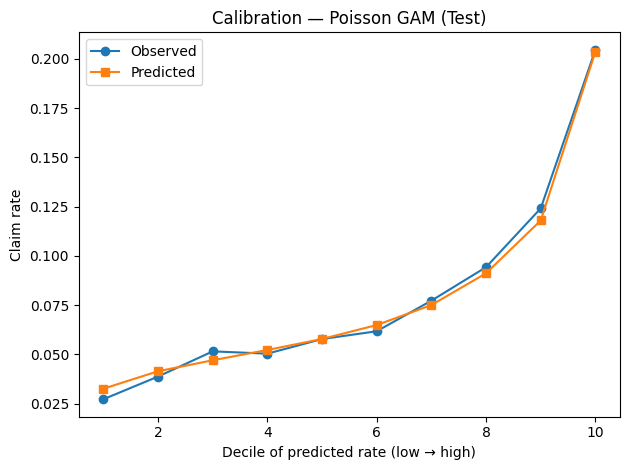

In [20]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print(cf2("Claim Frequency GAM, Test (Actual/Predicted)",
          y_test_counts, w_test, pred_counts, w_test))
print(f"Poisson Deviance GAM, Test: {pdw(pred_counts, y_test_counts, w_test):.2f}%")

# Reliability / Dezile
pred_rate = pred_counts / w_test
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({"dec":dec, "expo":w_test, "claims":y_test_counts, "pred":pred_counts})
       .groupby("dec")
       .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
       .assign(obs_rate=lambda d: d["claims"]/d["expo"],
               pred_rate=lambda d: d["pred"]/d["expo"])
       .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate")
plt.title("Calibration — Poisson GAM (Test)")
plt.legend(); plt.tight_layout(); plt.show()

## GAM – Kurzfazit & Vergleich zu GLM1/GLM2

**Setup.**  
Poisson-GAM für die **Rate** $y=\frac{\text{ClaimNb}}{\text{Exposure}}$ mit **Gewichten** $w=\text{Exposure}$  
(äquivalent zu einem Offset $\log(\text{Exposure})$). Terme:
- glatt: $s(\text{VehAge}) + s(\text{DrivAge}) + s(\text{BonusMalusGLM})$
- kategorial: $f(\text{VehPowerGLM}) + f(\text{VehGas}) + f(\text{VehBrand}) + f(\text{Region})$
- linear: $l(\text{AreaGLM}) + l(\text{DensityGLM})$  
Split: 5 Folds (Seed 42), **Fold 5 = Test (~20 %)**.  
Vorhersage der Counts über $\hat\mu = \hat r \cdot \text{Exposure}$.

**Ergebnisse (Test).**
- Claim Frequency (Actual/Predicted): **7.38 % / 7.36 %**  → **Niveau-Kalibrierung passt**
- Poisson Deviance: **GAM 29.16 %**  *(besser als GLM1 **29.55 %** und GLM2 **29.52 %**; INT **31.26 %**)*

**Interpretation.**  
Die glatten Terme bilden die erwartete **U-Form** von Fahreralter sowie die **nichtlineare** Wirkung des Bonus-Malus plausibel ab. Das führt zu einer **robust besseren Güte** (PDW↓) bei unveränderter Mittelwertkalibrierung.





In [24]:
def decile_calibration(y_true, y_pred, w=None, n_deciles=10):
    """
    Gruppiert Beobachtungen in Quantile nach y_pred und berechnet
    tatsächliche vs. vorhergesagte Werte je Decile.
    Für Kalibrierungsplots (Actual vs. Predicted).
    
    Parameters
    ----------
    y_true : array-like
        Zielvariable (z. B. ClaimNb, Severity, Pure Premium)
    y_pred : array-like
        Modellvorhersagen (gleiche Länge)
    w : array-like or None
        Gewichte (z. B. Exposure)
    n_deciles : int
        Anzahl der Quantilgruppen

    Returns
    -------
    DataFrame mit Spalten:
        dec, actual, pred, count, weight
    """
    df = pd.DataFrame({"y": y_true, "mu": y_pred})
    if w is not None:
        df["w"] = w
    else:
        df["w"] = 1.0

    df["dec"] = pd.qcut(df["mu"].rank(method="first"), n_deciles, labels=False) + 1
    out = df.groupby("dec").apply(lambda g: pd.Series({
        "actual": (g["w"] * g["y"]).sum() / g["w"].sum(),
        "pred":   (g["w"] * g["mu"]).sum() / g["w"].sum(),
        "count":  len(g),
        "weight": g["w"].sum()
    })).reset_index()

    return out


In [25]:
import os
PROJECT_ROOT = os.path.abspath("..")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

/tmp/ipykernel_12413/3416237369.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("dec").apply(lambda g: pd.Series({


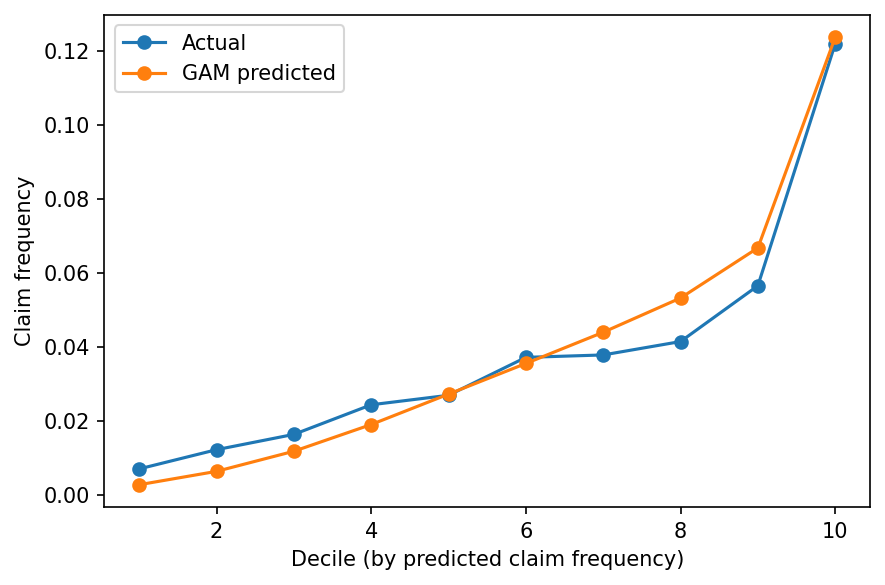

In [33]:
# 1) GAM-Counts (aus Rate * Exposure)
rate_gam_test   = gam.predict_mu(X_test)      # E[Rate] 
pred_counts_gam = rate_gam_test * w_test      # E[ClaimNb]

# 2) Dezil-Kalibrierung 
cal = decile_calibration(
    y_test_counts,        # observed counts
    pred_counts_gam,      # gam
    w=w_test              # exposure
)

# 3) Plot wie gehabt
plt.figure(figsize=(6,4), dpi=150)
plt.plot(cal['dec'], cal['actual'], 'o-', label='Actual')
plt.plot(cal['dec'], cal['pred'],   'o-', label='GAM predicted')
plt.xlabel('Decile (by predicted claim frequency)')
plt.ylabel('Claim frequency')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "calibration_gam.png"), dpi=150, bbox_inches="tight")
plt.show()


/tmp/ipykernel_12413/3416237369.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("dec").apply(lambda g: pd.Series({


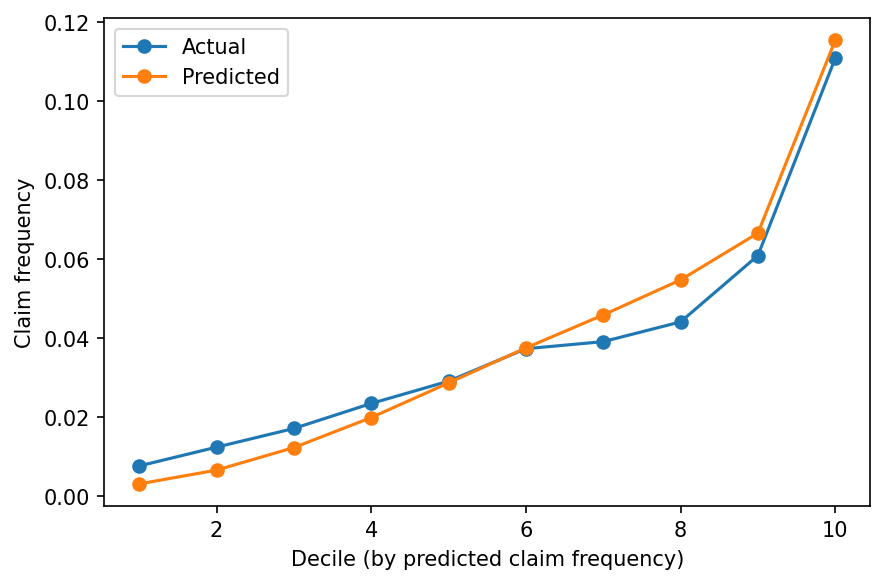

In [32]:
cal = decile_calibration(
    y_test_counts,           # Zielvariable (observed claim counts)
    test_pred_glm2,          # beste Schätzung, z.B. GLM2 oder GAM
    w=w_test                 # Exposure
)

plt.figure(figsize=(6,4), dpi=150)
plt.plot(cal['dec'], cal['actual'], 'o-', label='Actual')
plt.plot(cal['dec'], cal['pred'], 'o-', label='Predicted')
plt.xlabel('Decile (by predicted claim frequency)')
plt.ylabel('Claim frequency')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "calibration_glm2.png"), dpi=150, bbox_inches="tight")
plt.show()


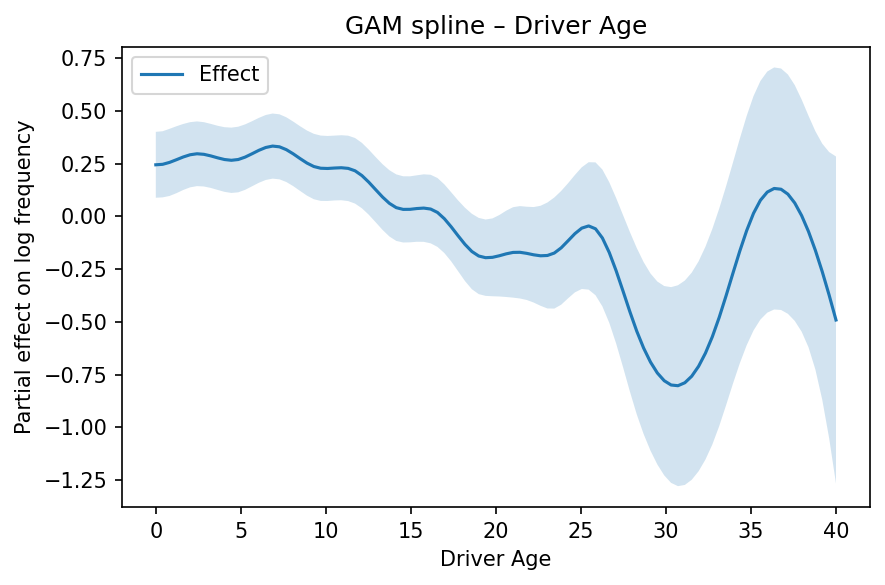

In [27]:
XX = gam.generate_X_grid(term=0)
pdep, confi = gam.partial_dependence(term=0, width=0.95)

#passt die form?
if confi.shape[0] == pdep.shape[0] and confi.shape[1] == 2:
    lower, upper = confi[:, 0], confi[:, 1]
elif confi.shape[0] == 2 and confi.shape[1] == pdep.shape[0]:
    lower, upper = confi[0], confi[1]
else:
    raise ValueError(f"Unexpected shape for confi: {confi.shape}")

plt.figure(figsize=(6,4), dpi=150)
plt.plot(XX[:, 0], pdep, label="Effect")
plt.fill_between(XX[:, 0], lower, upper, alpha=0.2)
plt.xlabel("Driver Age")
plt.ylabel("Partial effect on log frequency")
plt.title("GAM spline – Driver Age")
plt.legend(); plt.tight_layout()
plt.savefig("../figures/gam_spline_drivage.png", dpi=150, bbox_inches="tight")
plt.show()


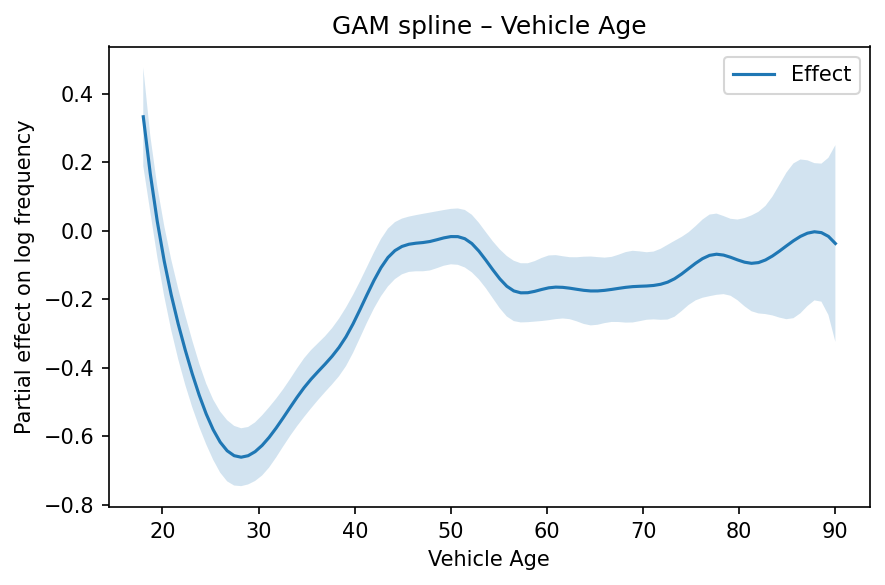

In [28]:
XX = gam.generate_X_grid(term=1)  
pdep, confi = gam.partial_dependence(term=1, width=0.95)
if confi.shape[0] == pdep.shape[0] and confi.shape[1] == 2:
    lower, upper = confi[:, 0], confi[:, 1]
else:
    lower, upper = confi[0], confi[1]

plt.figure(figsize=(6,4), dpi=150)
plt.plot(XX[:, 1], pdep, label="Effect")
plt.fill_between(XX[:, 1], lower, upper, alpha=0.2)
plt.xlabel("Vehicle Age")
plt.ylabel("Partial effect on log frequency")
plt.title("GAM spline – Vehicle Age")
plt.legend(); plt.tight_layout()
plt.savefig("../figures/gam_spline_vehage.png", dpi=150, bbox_inches="tight")
plt.show()


Gini (GLM1): 0.299
Gini (GLM2): 0.301
Gini (GAM):  0.299


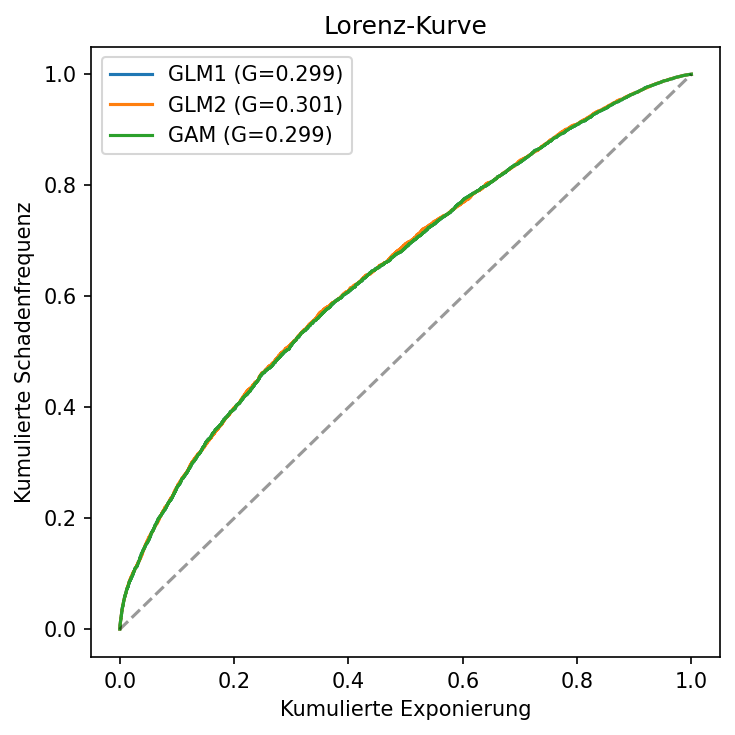

In [29]:
def gini(actual, pred, w=None):
    """Berechnet gewichteten Gini-Koeffizienten."""
    if w is None:
        w = np.ones_like(actual)
    order = np.argsort(-pred)  
    actual, w = actual[order], w[order]
    cum_actual = np.cumsum(actual * w)
    cum_weight = np.cumsum(w)
    total_actual = cum_actual[-1]
    total_weight = cum_weight[-1]
    lorenz = cum_actual / total_actual
    cum_weight = cum_weight / total_weight
    gini_coef = 2 * np.trapezoid(lorenz, cum_weight) - 1
    return gini_coef, lorenz, cum_weight


# Gini + Lorenz für alle drei Modelle
g_glm1, lor_glm1, cw = gini(y_test_counts, test_pred_glm1, w_test)
g_glm2, lor_glm2, _  = gini(y_test_counts, test_pred_glm2, w_test)
g_gam,  lor_gam,  _  = gini(y_test_counts, test_pred,       w_test)

print(f"Gini (GLM1): {g_glm1:.3f}")
print(f"Gini (GLM2): {g_glm2:.3f}")
print(f"Gini (GAM):  {g_gam:.3f}")

# Lorenz-Kurve
plt.figure(figsize=(5,5), dpi=150)
plt.plot(cw, lor_glm1, label=f"GLM1 (G={g_glm1:.3f})")
plt.plot(cw, lor_glm2, label=f"GLM2 (G={g_glm2:.3f})")
plt.plot(cw, lor_gam,  label=f"GAM (G={g_gam:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("Kumulierte Exponierung")
plt.ylabel("Kumulierte Schadenfrequenz")
plt.title("Lorenz-Kurve")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/lorenz_glm_gam.png", dpi=150, bbox_inches="tight")
plt.show()


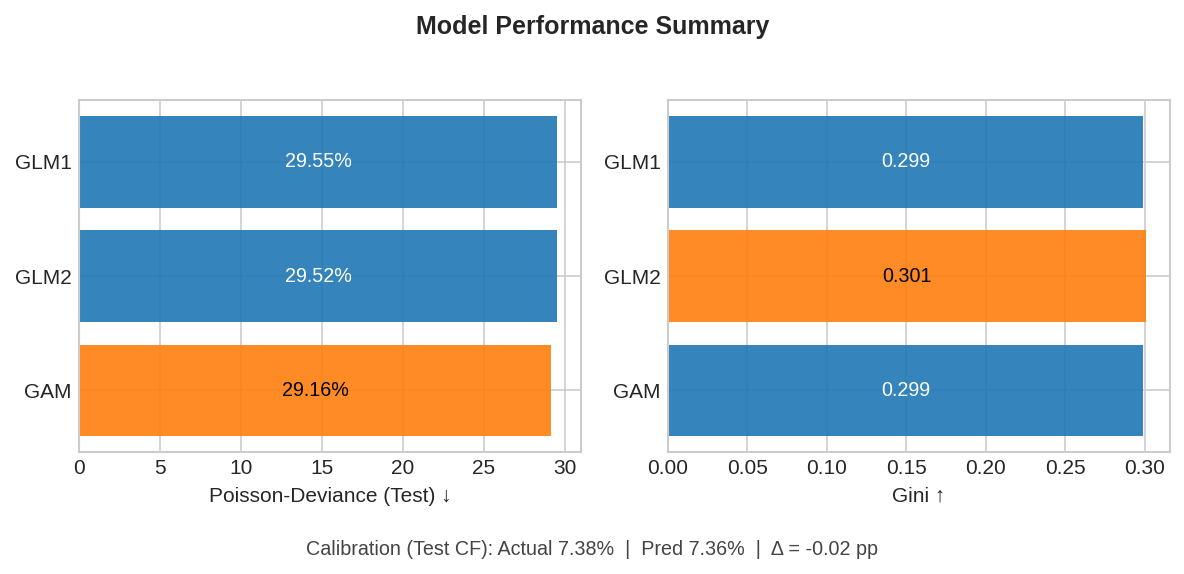

In [34]:
# --- Daten ---
models = ["GLM1", "GLM2", "GAM"]
pdw_vals = [29.55, 29.52, 29.16]
gini_vals = [0.299, 0.301, 0.299]
cf_actual, cf_pred = 7.38, 7.36
calib_delta = cf_pred - cf_actual

# --- Layout & Stil ---
plt.style.use("seaborn-v0_8-whitegrid")
os.makedirs("../figures", exist_ok=True)
fig, axes = plt.subplots(1, 2, figsize=(8, 3.6), dpi=150)
ax1, ax2 = axes

highlight = "#1f77b4"  # Blau
accent = "#ff7f0e"     # Orange

# -----------------------------
# Poisson Deviance 
# -----------------------------
y = np.arange(len(models))
colors_pdw = [accent if i == np.argmin(pdw_vals) else highlight for i in range(len(models))]
bars1 = ax1.barh(y, pdw_vals, color=colors_pdw, alpha=0.9)

ax1.set_yticks(y, models)
ax1.invert_yaxis()
ax1.set_xlabel("Poisson-Deviance (Test) ↓")

for i, (bar, v) in enumerate(zip(bars1, pdw_vals)):
    text_color = "black" if colors_pdw[i] == accent else "white"
    ax1.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
             f"{v:.2f}%", va="center", ha="center", fontsize=9.5, color=text_color)

# -----------------------------
# Gini 
# -----------------------------
colors_gini = [accent if i == np.argmax(gini_vals) else highlight for i in range(len(models))]
bars2 = ax2.barh(y, gini_vals, color=colors_gini, alpha=0.9)

ax2.set_yticks(y, models)
ax2.invert_yaxis()
ax2.set_xlabel("Gini ↑")

for i, (bar, v) in enumerate(zip(bars2, gini_vals)):
    text_color = "black" if colors_gini[i] == accent else "white"
    ax2.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
             f"{v:.3f}", va="center", ha="center", fontsize=9.5, color=text_color)

# -----------------------------
# Titel + Kalibrierung
# -----------------------------
fig.suptitle("Model Performance Summary", fontsize=12, fontweight="semibold", y=0.98)
txt = f"Calibration (Test CF): Actual {cf_actual:.2f}%  |  Pred {cf_pred:.2f}%  |  Δ = {calib_delta:+.2f} pp"
fig.text(0.5, -0.02, txt, ha="center", fontsize=9.5, color="#444")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../figures/perf_summary.png", bbox_inches="tight", dpi=150)
plt.show()


In [60]:
learn.to_parquet("../notebooks/data/learn.parquet", index=False)
test.to_parquet("../notebooks/data/test.parquet", index=False)

In [61]:
learn = pd.read_parquet("../notebooks/data/learn.parquet")
test  = pd.read_parquet("../notebooks/data/test.parquet")
learn.head()
test.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM,fold
0,13,0.52,6,2,38,50,B12,Regular,E,3003,Nord-Pas-de-Calais,0,5,6,2,4,50,8.007367,5
1,27,0.87,7,0,56,50,B12,Diesel,C,173,Provence-Alpes-Cotes-D'Azur,0,3,7,1,6,50,5.153292,5
2,44,0.74,6,2,55,50,B12,Regular,A,37,Corse,0,1,6,2,6,50,3.610918,5
3,52,0.10,6,8,27,76,B3,Diesel,B,85,Provence-Alpes-Cotes-D'Azur,0,2,6,2,3,76,4.442651,5
4,58,0.03,5,0,59,50,B12,Regular,C,455,Languedoc-Roussillon,0,3,5,1,6,50,6.120297,5
